<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
> Целиков Сергей, DST-PRO-11



### Датасет собран и загружен, проведем его первичную обработку и начнем анализ данных

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LinearRegression


from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.base import clone
import math

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  4 2020, 02:22:02) 
Numpy        : 1.19.2


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 1
DIR_TRAIN  = './input/parsingauto/' # подключил к ноутбуку внешний датасет
DIR_TEST   = './input/sf-dst-car-price-prediction/'
VAL_SIZE   = 0.20   # 20%

# Data

In [7]:
!ls '../input'

ls: ../input: No such file or directory


In [8]:
train = pd.read_csv(DIR_TRAIN+'full_out.csv')  # датасет для обучения модели
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head(5)

,Unnamed: 0,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,...,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,Unnamed: 0.1
0,0,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/11027112...,чёрный,4.8 LTR,355 N12,бензин,260000.0,2006.0,...,автоматическая,3 или более,1 год и 2 месяца,Дубликат,полный,Левый,Не требует ремонта,Растаможен,1299999.0,0.0
1,1,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1102761...,синий,2.0 LTR,184 N12,бензин,129000.0,2011.0,...,автоматическая,2 владельца,7 лет и 9 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1320000.0,1.0
2,2,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1102058...,чёрный,2.0 LTR,184 N12,бензин,111000.0,2011.0,...,автоматическая,1 владелец,7 лет и 2 месяца,Оригинал,задний,Левый,Не требует ремонта,Растаможен,1340000.0,2.0
3,3,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x5/11019363...,чёрный,3.0 LTR,249 N12,дизель,1751.0,2018.0,...,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,6800000.0,3.0
4,4,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x3/11020571...,белый,2.0 LTR,245 N12,бензин,90122.0,2014.0,...,автоматическая,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1634000.0,4.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47954 entries, 0 to 47953
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            47954 non-null  int64  
 1   bodyType              47923 non-null  object 
 2   brand                 47927 non-null  object 
 3   car_url               47927 non-null  object 
 4   color                 47927 non-null  object 
 5   engineDisplacement    47927 non-null  object 
 6   enginePower           47927 non-null  object 
 7   fuelType              47923 non-null  object 
 8   mileage               47927 non-null  float64
 9   modelDate             47923 non-null  float64
 10  model_name            47941 non-null  object 
 11  numberOfDoors         47923 non-null  float64
 12  priceCurrency         47923 non-null  object 
 13  productionDate        47923 non-null  float64
 14  sell_id               47927 non-null  float64
 15  vehicleConfiguratio

In [11]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

## Data Preprocessing

### Разберемся с датасетом train 

In [13]:
train.sample(5)

,Unnamed: 0,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,...,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,Unnamed: 0.1
15258,15258,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/tigu...,красный,2.0 LTR,170 N12,бензин,134000.0,2007.0,...,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,844900.0,6312.0
32847,32847,внедорожник 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/rav_4/11...,бежевый,2.0 LTR,152 N12,бензин,150250.0,2005.0,...,автоматическая,2 владельца,8 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,895000.0,3345.0
11549,11549,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,белый,1.6 LTR,105 N12,бензин,172194.0,2009.0,...,автоматическая,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,450000.0,2603.0
17389,17389,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/jett...,чёрный,1.6 LTR,105 N12,бензин,105133.0,2010.0,...,автоматическая,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,570000.0,8443.0
5034,5034,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x6/11021768...,чёрный,3.0 LTR,306 N12,бензин,100950.0,2007.0,...,автоматическая,1 владелец,10 лет и 4 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1550000.0,5034.0


In [14]:
train.isna().sum()

Unnamed: 0                  0
bodyType                   31
brand                      27
car_url                    27
color                      27
engineDisplacement         27
enginePower                27
fuelType                   31
mileage                    27
modelDate                  31
model_name                 13
numberOfDoors              31
priceCurrency              31
productionDate             31
sell_id                    27
vehicleConfiguration       31
vehicleTransmission        31
Владельцы                  27
Владение                35499
ПТС                        28
Привод                     31
Руль                       27
Состояние                  27
Таможня                    27
price                    3474
Unnamed: 0.1                0
dtype: int64

In [15]:
# Уберем пустые строки
train.drop(['Владение'], inplace=True, axis = 1)

In [16]:
train.drop(['Unnamed: 0'], inplace=True, axis = 1)

In [17]:
train.drop(['Unnamed: 0.1'], inplace=True, axis = 1)

In [18]:
train.isna().sum()

bodyType                  31
brand                     27
car_url                   27
color                     27
engineDisplacement        27
enginePower               27
fuelType                  31
mileage                   27
modelDate                 31
model_name                13
numberOfDoors             31
priceCurrency             31
productionDate            31
sell_id                   27
vehicleConfiguration      31
vehicleTransmission       31
Владельцы                 27
ПТС                       28
Привод                    31
Руль                      27
Состояние                 27
Таможня                   27
price                   3474
dtype: int64

In [19]:
train.dropna(inplace=True)

In [20]:
train.isna().sum()

bodyType                0
brand                   0
car_url                 0
color                   0
engineDisplacement      0
enginePower             0
fuelType                0
mileage                 0
modelDate               0
model_name              0
numberOfDoors           0
priceCurrency           0
productionDate          0
sell_id                 0
vehicleConfiguration    0
vehicleTransmission     0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
Состояние               0
Таможня                 0
price                   0
dtype: int64

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44478 entries, 0 to 47953
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              44478 non-null  object 
 1   brand                 44478 non-null  object 
 2   car_url               44478 non-null  object 
 3   color                 44478 non-null  object 
 4   engineDisplacement    44478 non-null  object 
 5   enginePower           44478 non-null  object 
 6   fuelType              44478 non-null  object 
 7   mileage               44478 non-null  float64
 8   modelDate             44478 non-null  float64
 9   model_name            44478 non-null  object 
 10  numberOfDoors         44478 non-null  float64
 11  priceCurrency         44478 non-null  object 
 12  productionDate        44478 non-null  float64
 13  sell_id               44478 non-null  float64
 14  vehicleConfiguration  44478 non-null  object 
 15  vehicleTransmission

In [22]:
train['mileage'] = train['mileage'].apply(int)
train['modelDate'] = train['modelDate'].apply(int)
train['numberOfDoors'] = train['numberOfDoors'].apply(int)
train['productionDate'] = train['productionDate'].apply(int)
train['sell_id'] = train['sell_id'].apply(int)
train['price'] = train['price'].apply(int)

###  Оставляем только те признаки, с которыми имеет смысл работать:

In [23]:
train.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name',
       'numberOfDoors', 'priceCurrency', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'price'],
      dtype='object')

In [24]:
train.drop(['priceCurrency', 'car_url'], inplace=True, axis=1)

In [25]:
train.nunique()

bodyType                   24
brand                      12
color                      16
engineDisplacement         55
enginePower               307
fuelType                    5
mileage                 10688
modelDate                  66
model_name                522
numberOfDoors               4
productionDate             65
sell_id                 27048
vehicleConfiguration      603
vehicleTransmission         4
Владельцы                   3
ПТС                         2
Привод                      3
Руль                        2
Состояние                   2
Таможня                     2
price                    3483
dtype: int64

In [26]:
# Убираем колонки, в которых слишком много категориальных признаков
train.drop(['model_name', 'vehicleConfiguration'], inplace=True, axis=1)

In [27]:
train.drop_duplicates(subset=['sell_id'], inplace=True)

In [28]:
train.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate',
       'sell_id', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'Состояние', 'Таможня', 'price'],
      dtype='object')

### Посмотрим на dataset test

In [29]:
columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
           'fuelType', 'mileage', 'modelDate', 'numberOfDoors', 'productionDate',
           'sell_id', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль',
           'Состояние', 'Таможня']
test = test[columns]

In [30]:
test.nunique()

bodyType                  24
brand                     12
color                     16
engineDisplacement        55
enginePower              315
fuelType                   5
mileage                11268
modelDate                 66
numberOfDoors              5
productionDate            69
sell_id                34686
vehicleTransmission        4
Владельцы                  3
ПТС                        2
Привод                     3
Руль                       2
Состояние                  1
Таможня                    1
dtype: int64

In [31]:
test['Состояние'].unique()

array(['Не требует ремонта'], dtype=object)

In [32]:
test['Таможня'].unique()

array(['Растаможен'], dtype=object)

In [33]:
# Уберем признаки Состояние, Таможня как не несущие смысловой нагрузки
train = train[train['Состояние'] == 'Не требует ремонта']
train = train[train['Таможня'] == 'Растаможен']

In [34]:
train.drop(['Состояние', 'Таможня'], inplace=True, axis=1)
test.drop(['Состояние', 'Таможня'], inplace=True, axis=1)

In [35]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
df = train.append(test, ignore_index=True)

## Найдем дупликаты по sell_id между train и test 
### Для избежания утечки данных

In [36]:
duplicates = df.duplicated(subset=['sell_id'], keep=False)

In [37]:
duplicates.value_counts()

False    56340
True      5390
dtype: int64

In [38]:
# удалим только те дубликаты, которые в трейне:
df = df[~duplicates | (df['sample'] != 1)]

In [39]:
df['sample'].value_counts()

0    34686
1    24349
Name: sample, dtype: int64

## Преобразуем признаки

In [40]:
df.sample(10)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,price,sample
13852,седан,TOYOTA,чёрный,2.5 LTR,181 N12,бензин,75451,2011,4,2013,1103131886,автоматическая,2 владельца,Оригинал,передний,Левый,1375000.0,1
40548,внедорожник 5 дв.,NISSAN,красный,2.0 LTR,141 N12,бензин,189000,2006,5,2008,1101315258,вариатор,2 владельца,Оригинал,полный,Левый,NaN,0
42210,внедорожник 5 дв.,INFINITI,серый,3.5 LTR,302 N12,бензин,158000,2007,5,2008,1094110346,автоматическая,3 или более,Оригинал,полный,Левый,NaN,0
46145,хэтчбек 3 дв.,TOYOTA,красный,1.3 LTR,101 N12,бензин,145000,2009,3,2009,1100486688,механическая,1 владелец,Оригинал,передний,Левый,NaN,0
27684,лифтбек,SKODA,белый,1.4 LTR,125 N12,бензин,97000,2012,5,2016,1087080897,роботизированная,1 владелец,Оригинал,передний,Левый,NaN,0
39247,седан,NISSAN,чёрный,2.5 LTR,182 N12,бензин,176953,2011,4,2012,1101141182,вариатор,2 владельца,Оригинал,передний,Левый,NaN,0
23097,лифтбек,SKODA,белый,1.4 LTR,150 N12,бензин,99500,2015,5,2019,1102907232,роботизированная,1 владелец,Оригинал,передний,Левый,1680000.0,1
40221,седан,NISSAN,серый,3.5 LTR,249 N12,бензин,170000,2011,4,2011,1101114656,вариатор,3 или более,Дубликат,передний,Левый,NaN,0
38076,хэтчбек 5 дв.,BMW,белый,2.0 LTR,204 N12,дизель,84000,2007,5,2010,1100800878,механическая,3 или более,Дубликат,задний,Левый,NaN,0
22578,лифтбек,SKODA,серый,1.4 LTR,122 N12,бензин,172000,2008,5,2011,1101199766,механическая,3 или более,Оригинал,передний,Левый,550000.0,1


### Исправление признака engineDisplacement

Преобразуем данный признак в числовой

In [41]:
df['engineDisplacement'] = df['engineDisplacement'].apply(
    lambda x: '0.0 LTR' if x == ' LTR' else x)
df['eng_disp_num'] = (df['engineDisplacement'].str.split())
df['eng_disp_num'] = df['eng_disp_num'].apply(lambda x: float(x[0]))
df.drop(['engineDisplacement'], inplace=True, axis=1)

### Исправление признака enginePower

Преобразуем данный признак в числовой

In [42]:
df['eng_pow_num'] = (df['enginePower'].str.split())
df['eng_pow_num'] = df['eng_pow_num'].apply(lambda x: float(x[0]))
df.drop(['enginePower'], inplace=True, axis=1)

In [43]:
# в датасете есть 2 бинарных признакa, 8 категориальных и 5 числовых.
# sell_id исключили из списка - идентификатор, нужен только для submission
# price - целевая переменная

bin_cols = ['ПТС', 'Руль']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType',
            'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод']
num_cols = ['mileage', 'modelDate',
            'productionDate', 'eng_disp_num', 'eng_pow_num']

### Исследуем числовые признаки

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59035 entries, 0 to 61729
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             59035 non-null  object 
 1   brand                59035 non-null  object 
 2   color                59035 non-null  object 
 3   fuelType             59035 non-null  object 
 4   mileage              59035 non-null  int64  
 5   modelDate            59035 non-null  int64  
 6   numberOfDoors        59035 non-null  int64  
 7   productionDate       59035 non-null  int64  
 8   sell_id              59035 non-null  int64  
 9   vehicleTransmission  59035 non-null  object 
 10  Владельцы            59035 non-null  object 
 11  ПТС                  59034 non-null  object 
 12  Привод               59035 non-null  object 
 13  Руль                 59035 non-null  object 
 14  price                24349 non-null  float64
 15  sample               59035 non-null 

In [45]:
# визуализируем числовые признаки
def visualize(data, col, size=6):
    fig, ax = plt.subplots(2, 2, figsize=(2*size, 2*size))
    fig.suptitle('Histogram and boxplot for {0} '.format(col), fontsize=20)
    ax[0, 0].hist(data[col], bins=20, histtype='bar', align='mid',
                  rwidth=0.8, color='blue')  # гистограмма
    ax[0, 1].boxplot(data[col], vert=False)
    ax[1, 0].hist(np.log(data[col] + 1), bins=20, histtype='bar',
                  align='mid', rwidth=0.8, color='blue')  # гистограмма
    ax[1, 1].boxplot(np.log(data[col] + 1), vert=False)  # выбросы
    ax[1, 0].set(title='log (' + col + ')')
    ax[1, 1].set(title='log (' + col + ')')
    ax[0, 0].set(title=col)
    ax[0, 1].set(title=col)
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.show()


# Поиск выбросов
def outliers(data, col):
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l = perc25 - 1.5*IQR
    r = perc75 + 1.5*IQR
    print("Для {0} IQR: {1}, ".format(col, IQR),
          "Границы выбросов: [{0}, {1}].".format(l, r))
    print('Всего {} выбросов'.format(
        data[data[col] > r][col].count() + data[data[col] < l][col].count()))
    print('Медиана:', median)
    print('Среднее:', data[col].mean())
    print('Среднеквадратичное отклонение:', data[col].std())

### mileage

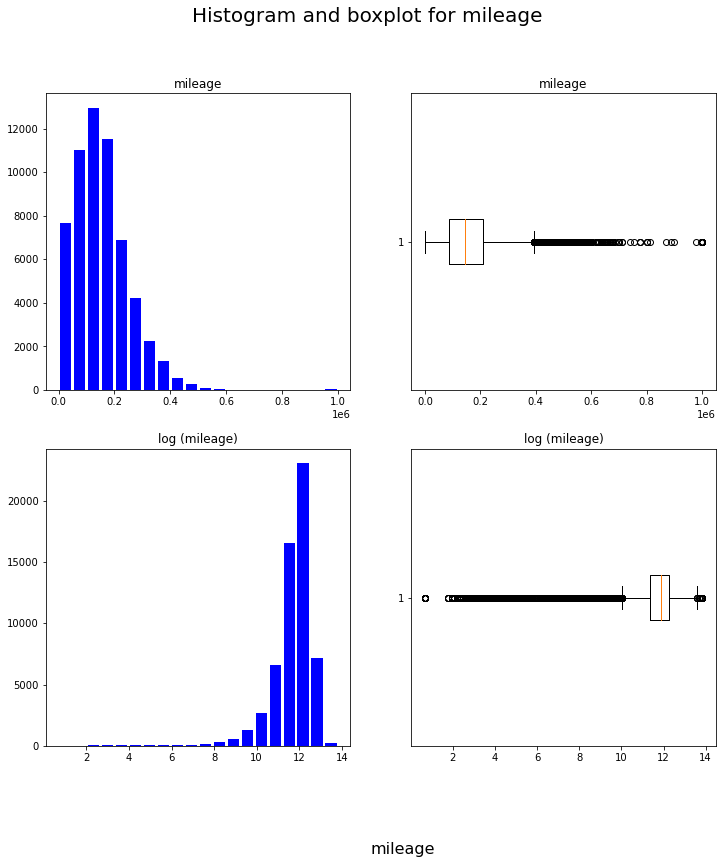

In [46]:
visualize(df, 'mileage')

In [47]:
# Вывод - мы имеем логнормальное распределение, возьмем логарифм от признака.
df['mileage'] = np.log(df['mileage'] + 1)

### modelDate

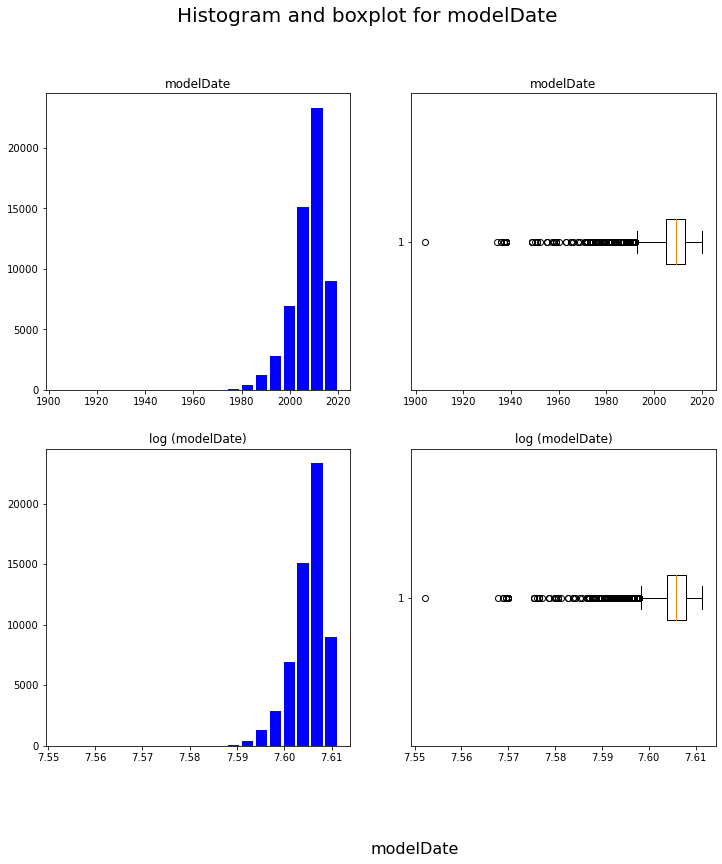

In [48]:
visualize(df, 'modelDate')

У нас есть два признака, обозначающих дату - modelDate и productionDate. 

Очевидно, что они взаимосвязаны. 
Заменим признак productionDate на разницу productionDate - modelDate 


In [49]:
df['modelDate'] = df['productionDate'] - df['modelDate']

Присутствуют значения, где modelDate более поздняя, чем productionDate. Это явно ошибка, заменим на 0

In [50]:
df['modelDate'] = df['modelDate'].apply(lambda x: 0 if x < 0 else x)

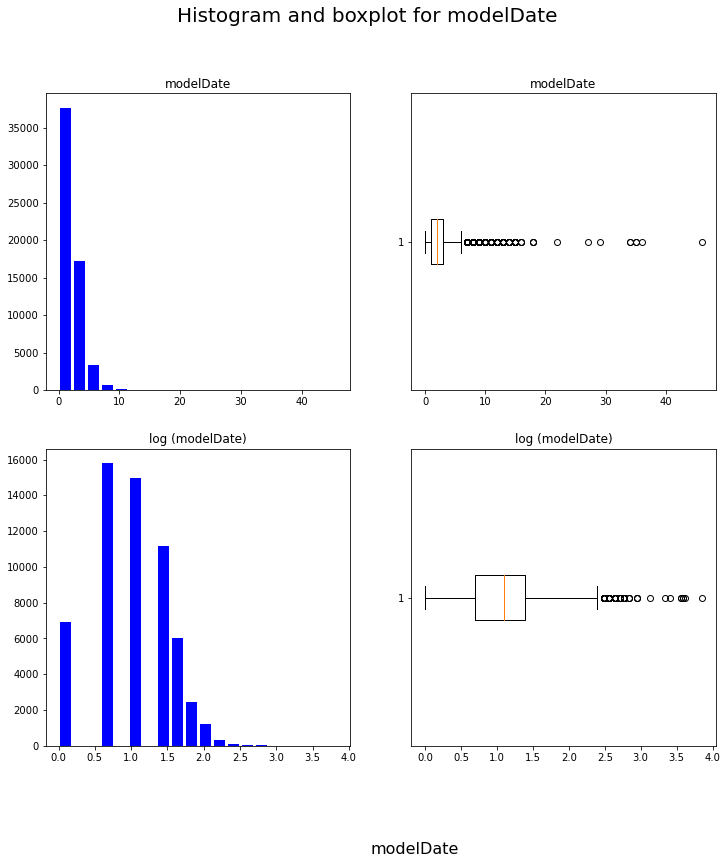

In [51]:
visualize(df, 'modelDate')

In [52]:
outliers(df, 'modelDate')

Для modelDate IQR: 2.0,  Границы выбросов: [-2.0, 6.0].
Всего 830 выбросов
Медиана: 2.0
Среднее: 2.167612433302278
Среднеквадратичное отклонение: 1.6387219650397171


In [53]:
# Вывод - мы имеем логнормальное распределение, возьмем логарифм от признака.
df['modelDate'] = np.log(df['modelDate'] + 1)

### productionDate

In [54]:
df['productionDate'].describe()

count    59035.000000
mean      2010.022783
std          6.935620
min       1904.000000
25%       2007.000000
50%       2011.000000
75%       2015.000000
max       2021.000000
Name: productionDate, dtype: float64

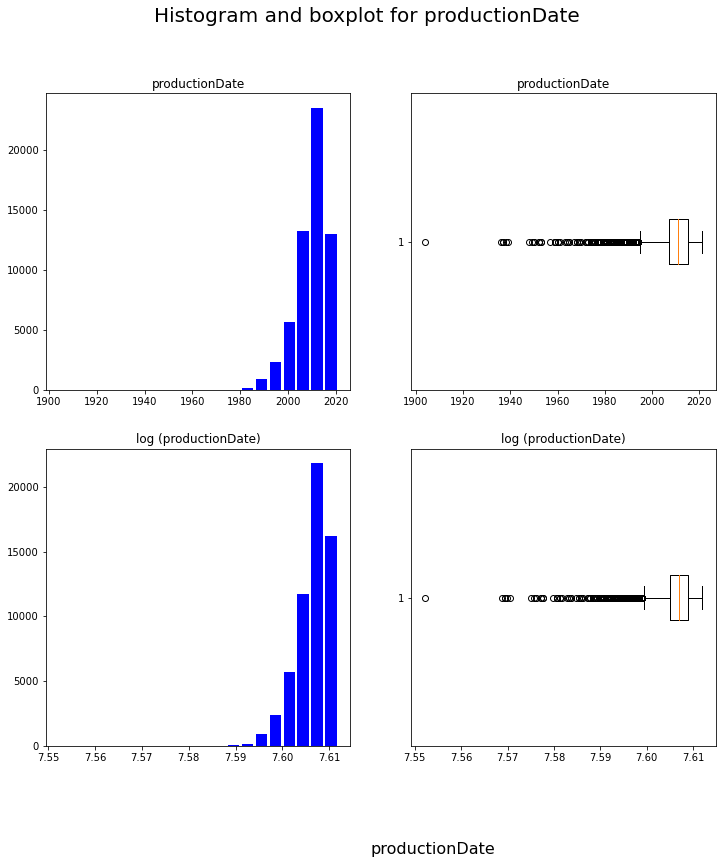

In [55]:
visualize(df, 'productionDate')

### Вывод - распределение похоже на нормальное, оставляем признак без изменения.

### eng_disp_num

In [56]:
df['eng_disp_num'].describe()

count    59035.000000
mean         2.393065
std          0.958793
min          0.000000
25%          1.800000
50%          2.000000
75%          3.000000
max          6.600000
Name: eng_disp_num, dtype: float64

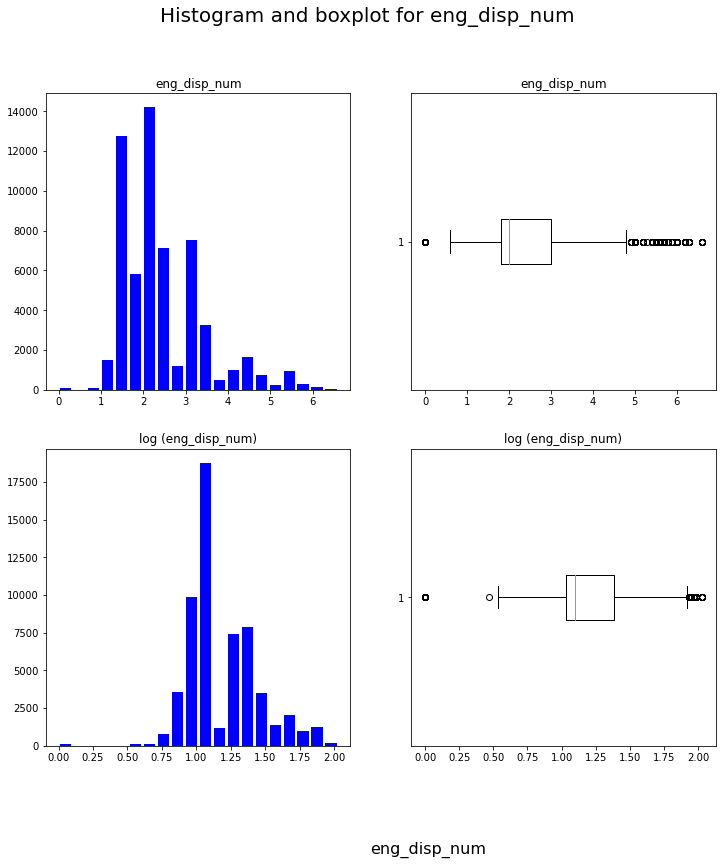

In [57]:
visualize(df, 'eng_disp_num')

In [58]:
# Вывод - мы имеем логнормальное распределение, возьмем логарифм от признака.
df['eng_disp_num'] = np.log(df['eng_disp_num'] + 1)

### eng_pow_num

In [59]:
df['eng_pow_num'].describe()

count    59035.000000
mean       189.082476
std         88.569491
min          7.000000
25%        129.000000
50%        170.000000
75%        235.000000
max        639.000000
Name: eng_pow_num, dtype: float64

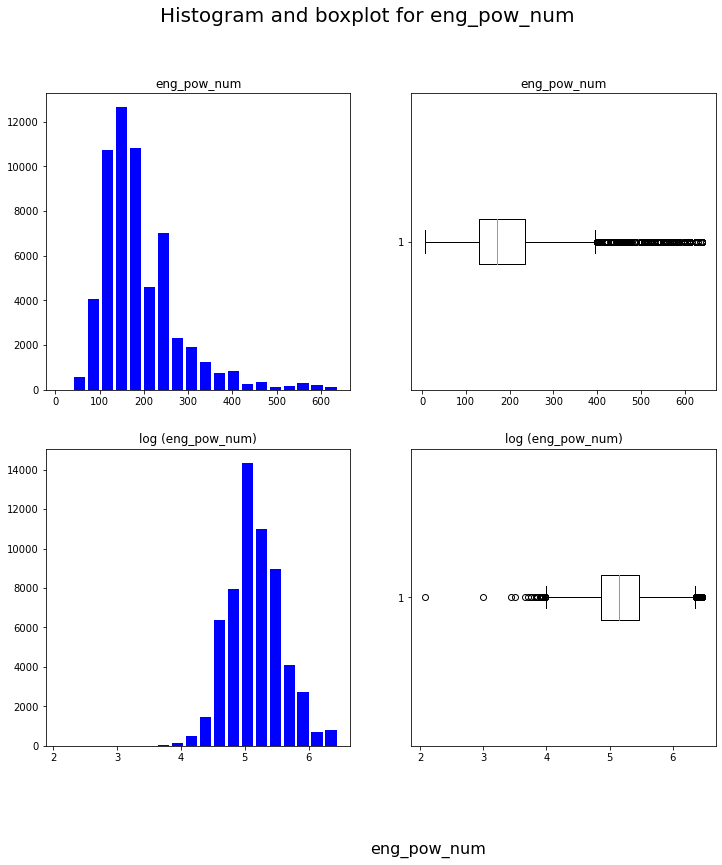

In [60]:
visualize(df, 'eng_pow_num')

In [61]:
# Вывод - мы имеем логнормальное распределение, возьмем логарифм от признака.
df['eng_pow_num'] = np.log(df['eng_pow_num'] + 1)

<AxesSubplot:>

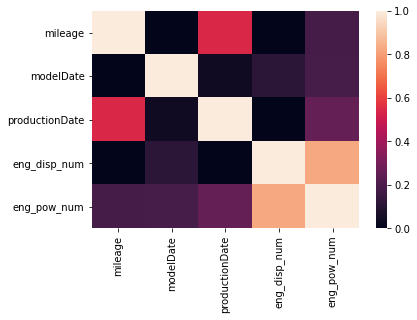

In [62]:
# Оценим корреляцию Пирсона для непрерывных переменных
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

<AxesSubplot:>

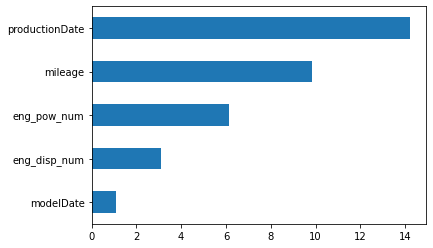

In [63]:
# Есть сильная корреляция между признаками eng_pow_num  и eng_disp_num.
# Возмижно, один из них следует удалить
# Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

imp_num = Series(f_classif(df[df['sample'] == 1][num_cols],
                           df[df['sample'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

## Исследуем категориальные признаки¶

In [64]:
display(cat_cols)

['bodyType',
 'brand',
 'color',
 'fuelType',
 'numberOfDoors',
 'vehicleTransmission',
 'Владельцы',
 'Привод']

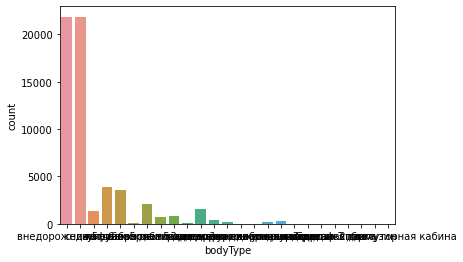

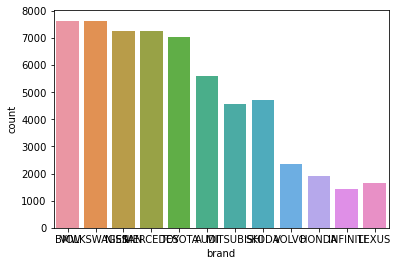

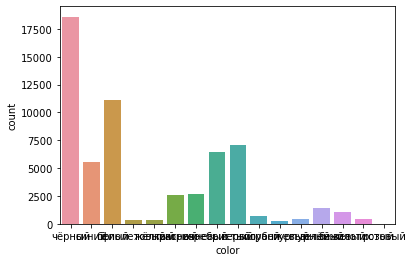

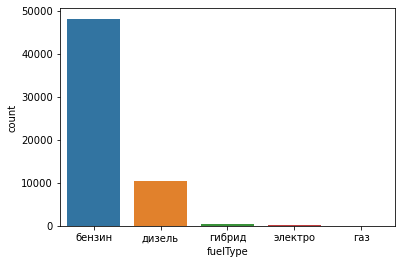

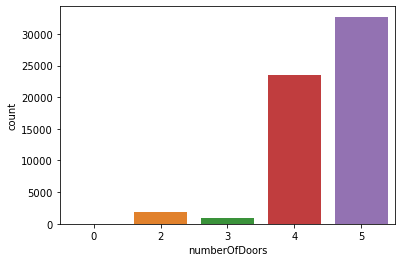

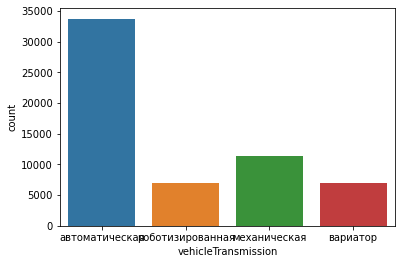

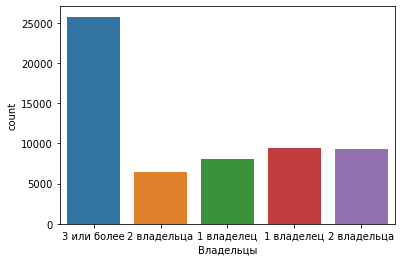

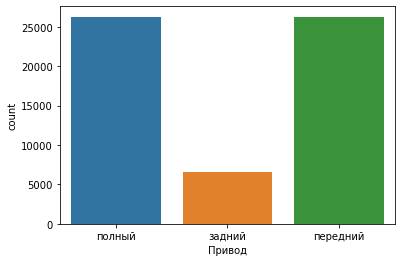

In [65]:
for col in cat_cols:
    sns.countplot(x=df[col])
    plt.show()

In [66]:
df['Владельцы'].unique()

array(['3 или более', '2 владельца', '1 владелец', '1\xa0владелец',
       '2\xa0владельца'], dtype=object)

### Исправим признак 'Владельцы'

In [67]:
df['Владельцы'] = df['Владельцы'].str.replace('\xa0', ' ')

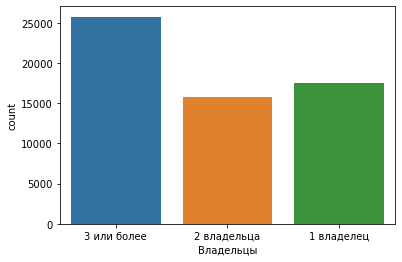

In [68]:
sns.countplot(x=df['Владельцы'])
plt.show()

In [69]:
# заменяем строковые значения в категориальных столбцах на числовые

encoder = LabelEncoder()

for column in cat_cols:
    encoder.fit(df[column])
    df[column] = encoder.transform(df[column])

## Исследуем бинарные признаки

In [70]:
display(bin_cols)

['ПТС', 'Руль']

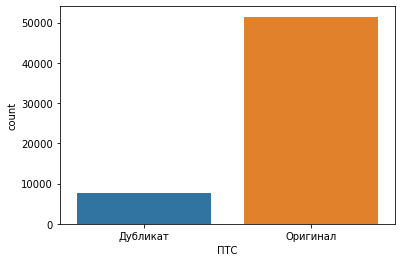

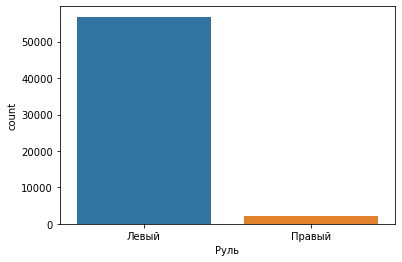

In [71]:
# визуализируем бинарные признаки:
for col in bin_cols:
    sns.countplot(x=df[col])
    plt.show()

In [72]:
# Исправим один пропуск в тестовых данных для признака "ПТС"
df['ПТС'] = df['ПТС'].fillna('Оригинал')

In [73]:
# перекодируем бинарные признаки
lbl_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = lbl_encoder.fit_transform(df[column])

In [74]:
# проверим результат
df.head(5)

,bodyType,brand,color,fuelType,mileage,modelDate,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,ПТС,Привод,Руль,price,sample,eng_disp_num,eng_pow_num
0,1,1,15,0,12.468441,1.386294,4,2009,1102711218,0,2,0,2,0,1299999.0,1,1.757858,5.874931
1,15,1,13,0,11.767575,1.098612,3,2013,1102761642,0,1,1,2,0,1320000.0,1,1.098612,5.220356
2,15,1,15,0,11.617294,1.098612,3,2013,1102058716,0,0,1,0,0,1340000.0,1,1.098612,5.220356
3,1,1,15,3,7.468513,1.098612,4,2020,1101936324,0,0,1,2,0,6800000.0,1,1.386294,5.521461
4,1,1,1,0,11.408931,0.693147,4,2015,1102057148,0,1,1,2,0,1634000.0,1,1.098612,5.505332


<AxesSubplot:>

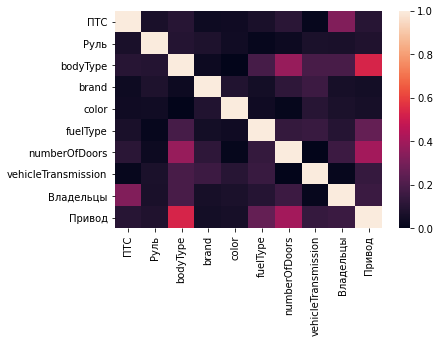

In [75]:
# Оценим взаимную корреляцию бинарных и категориальных признаков
sns.heatmap(df[bin_cols + cat_cols].corr().abs(), vmin=0, vmax=1)

<AxesSubplot:>

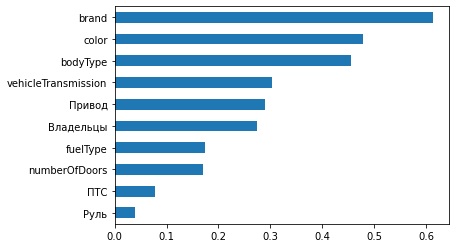

In [76]:
# проверим значимость бинарных и категориальных признаков
imp_cat = Series(mutual_info_classif(df[df['sample'] == 1][bin_cols + cat_cols], df[df['sample'] == 1]['price'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

### Сильной корреляции между переменными нет, пока оставляем все признаки.

In [77]:
# заменим все категориальные признаки на dummy переменные

df = pd.get_dummies(df, columns=cat_cols)

In [78]:
# Проверим результат
df.head()

,mileage,modelDate,productionDate,sell_id,ПТС,Руль,price,sample,eng_disp_num,eng_pow_num,...,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Привод_0,Привод_1,Привод_2
0,12.468441,1.386294,2009,1102711218,0,0,1299999.0,1,1.757858,5.874931,...,1,0,0,0,0,0,1,0,0,1
1,11.767575,1.098612,2013,1102761642,1,0,1320000.0,1,1.098612,5.220356,...,1,0,0,0,0,1,0,0,0,1
2,11.617294,1.098612,2013,1102058716,1,0,1340000.0,1,1.098612,5.220356,...,1,0,0,0,1,0,0,1,0,0
3,7.468513,1.098612,2020,1101936324,1,0,6800000.0,1,1.386294,5.521461,...,1,0,0,0,1,0,0,0,0,1
4,11.408931,0.693147,2015,1102057148,1,0,1634000.0,1,1.098612,5.505332,...,1,0,0,0,0,1,0,0,0,1


In [79]:
# удалим столбец sell_id, т.к. это идентификатор объявления

df = df.drop('sell_id', axis=1)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59035 entries, 0 to 61729
Data columns (total 82 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   mileage                59035 non-null  float64
 1   modelDate              59035 non-null  float64
 2   productionDate         59035 non-null  int64  
 3   ПТС                    59035 non-null  int64  
 4   Руль                   59035 non-null  int64  
 5   price                  24349 non-null  float64
 6   sample                 59035 non-null  int64  
 7   eng_disp_num           59035 non-null  float64
 8   eng_pow_num            59035 non-null  float64
 9   bodyType_0             59035 non-null  uint8  
 10  bodyType_1             59035 non-null  uint8  
 11  bodyType_2             59035 non-null  uint8  
 12  bodyType_3             59035 non-null  uint8  
 13  bodyType_4             59035 non-null  uint8  
 14  bodyType_5             59035 non-null  uint8  
 15  bo

## Поcтроим базовую модель

In [81]:
# разделяем наш объединенный ранее датасет на первоначальные части - train_df и test_df

train_dfm = df[df['sample'] == 1].drop(['sample'], axis=1)
test_dfm = df[df['sample'] == 0].drop(['sample'], axis=1)

In [82]:
X = train_dfm.drop(['price'], axis=1).values
y = train_dfm['price'].values

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Model 1. "Linear regression"

In [84]:
# Обучаем классификатор
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f}%")

Test MAPE: 78.370%


Результат:
Test MAPE: 78.370 %

## Model 2. Random Forest.

In [85]:
# Параметры леса по умолчанию леса по умолчанию
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Test MAPE: 15.130 %


Результат:
Test MAPE: 15.130%

Попробуем подобрать значения для некоторых параметров с помощью RandomizedSearchCV

In [86]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=1200, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [87]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, scoring="neg_mean_absolute_error", param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_train, y_train)

rf_random.best_params_

'\nrf = RandomForestRegressor()\nrf_random = RandomizedSearchCV(estimator = rf, scoring = "neg_mean_absolute_error", param_distributions = random_grid, \n                               n_iter = 100, cv = 3, verbose=2, random_state=RANDOM_SEED, n_jobs = -1)\nrf_random.fit(X_train, y_train)\n\nrf_random.best_params_\n'

In [88]:
best_parameters = rf_random.best_params_
print(f'Лучшие значения параметров:')
for param_name in sorted(best_parameters.keys()):
    print('  %s = %r,' % (param_name, best_parameters[param_name]))

"\nbest_parameters = rf_random.best_params_\nprint(f'Лучшие значения параметров:') \nfor param_name in sorted(best_parameters.keys()):\n        print('  %s = %r,' % (param_name, best_parameters[param_name]))\n"

Лучшие значения параметров:

  max_depth = None,
  
  max_features = 'auto',
  
  min_samples_leaf = 1,
  
  min_samples_split = 2,
  
  n_estimators = 500

In [89]:
# Построим RandomForest на лучших параметрах
bestparams_rf = RandomForestRegressor(random_state=RANDOM_SEED,
                                      max_depth=None,
                                      max_features='auto',
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      n_estimators=500)
bestparams_rf.fit(X_train, y_train)
y_pred = bestparams_rf.predict(X_test)

print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Test MAPE: 15.028 %


Результат:

Test MAPE: 15.028 %

Мы улучшили результат по сравнению с RandomForest с параметрами по умолчанию.


### Model 3. Bagging.

In [90]:
# Точность одного дерева
tree = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(f"Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Test MAPE: 20.126 %


Результат: Test MAPE: 20.126 %

In [91]:
# Обернем деревья в BaggingRegressor
tree = DecisionTreeRegressor(max_features=int(
    X_train.shape[1]/3), max_depth=77, random_state=RANDOM_SEED)
bagging_trees = BaggingRegressor(tree, random_state=RANDOM_SEED)
bagging_trees.fit(X_train, y_train)
y_pred = bagging_trees.predict(X_test)
print(
    f"BaggingRegressor(DecisionTrees) Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

BaggingRegressor(DecisionTrees) Test MAPE: 16.354 %


Результат:


BaggingRegressor(DecisionTrees) Test MAPE: 16.354 %

## Model 4. GradientBoosting Regressor.

In [92]:
# Запустим с параметрами по умолчанию.
gb = GradientBoostingRegressor(random_state=RANDOM_SEED)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

GradientBoostingRegressor Test MAPE: 22.124 %


Результат:

GradientBoostingRegressor Test MAPE: 22.124 %

In [93]:
# Попробуем провести поиск наилучших параметров
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=800, num=8)],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}

gbr = GradientBoostingRegressor()
gbr_r = RandomizedSearchCV(estimator=gbr, scoring="neg_mean_absolute_error", param_distributions=random_grid,
                           n_iter=100, cv=3, verbose=10, random_state=RANDOM_SEED, n_jobs=-1)
gbr_r.fit(X_train, y_train)
gbr_r.best_params_

'\ngbr = GradientBoostingRegressor()\ngbr_r = RandomizedSearchCV(estimator = gbr, scoring = "neg_mean_absolute_error", param_distributions = random_grid, \n                n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)\ngbr_r.fit(X_train, y_train)\ngbr_r.best_params_\n'

In [94]:
best_parameters = gbr_r.best_params_
print(f'Лучшие значения параметров:')
for param_name in sorted(best_parameters.keys()):
    print('  %s = %r,' % (param_name, best_parameters[param_name]))

"\nbest_parameters = gbr_r.best_params_\nprint(f'Лучшие значения параметров:') \nfor param_name in sorted(best_parameters.keys()):\n        print('  %s = %r,' % (param_name, best_parameters[param_name]))\n"

Лучшие значения параметров:

  max_depth = 7,
  
  max_features = 'auto',
  
  min_samples_leaf = 2,
  
  min_samples_split = 2,
  
  n_estimators = 500

In [95]:
# Запустим с найденными лучшими параметрами.
gb_bestpar = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                       max_depth=7,
                                       max_features='auto',
                                       min_samples_leaf=2,
                                       min_samples_split=2,
                                       n_estimators=500)
gb_bestpar.fit(X_train, y_train)
y_pred = gb_bestpar.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

GradientBoostingRegressor Test MAPE: 14.797 %


Результат:

GradientBoostingRegressor Test MAPE: 14.797 %

Результаты значительно лучше по сравнению с полученными с параметрами по умолчанию.

## Model 5. Bagging + GradientBoosting Regressor.
Попробуем объединить Bagging и GradientBoosting Regressor

In [96]:
# Запустим с GradientBoosting Regressor c найденными ранее оптимальными параметрами.
gb_bb = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                  max_depth=7,
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  n_estimators=500,
                                  max_features=int(X_train.shape[1]/3))
gb_bb.fit(X_train, y_train)
y_pred = gb_bb.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

GradientBoostingRegressor Test MAPE: 14.598 %


GradientBoostingRegressor Test MAPE: 14.598 %

In [97]:
# Обернем GradientBoosting Regressor в BaggingRegressor
bagging_gb = BaggingRegressor(gb_bb, random_state=RANDOM_SEED)
bagging_gb.fit(X_train, y_train)
y_pred = bagging_gb.predict(X_test)
print(
    f"Bagging+GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

Bagging+GradientBoostingRegressor Test MAPE: 14.306 %


### Результат

Bagging+GradientBoostingRegressor Test MAPE: 14.306 %

## Model 6. Stacking.

In [98]:
X_pred = test_dfm.drop(['price'], axis=1).values

In [99]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


def compute_metric(regressor, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    regressor.fit(X_train, y_train)
    y_test_pred = regressor.predict(X_test)
    return np.round(mape(y_test, y_test_pred)*100, 4)

In [100]:
def compute_meta_feature(regressor, X_train, X_test, y_train, cv, X_pred):

    X_meta_train = np.zeros_like(y_train, dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regressor)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regressor)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)
    X_meta_pred = meta_regr.predict(X_pred)

    return X_meta_train, X_meta_test, X_meta_pred

In [101]:
def generate_meta_features(regressors, X_train, X_test, y_train, cv, X_pred):

    features = [
        compute_meta_feature(regr, X_train, X_test, y_train, cv, X_pred) for regr in tqdm(regressors)
    ]
    stacked_features_train = np.vstack([
        features_train for features_train, features_test, features_pred in features
    ]).T
    stacked_features_test = np.vstack([
        features_test for features_train, features_test, features_pred in features
    ]).T
    stacked_features_pred = np.vstack([
        features_pred for features_train, features_test, features_pred in features
    ]).T
    return stacked_features_train, stacked_features_test, stacked_features_pred

In [102]:
# получаем метапризнаки:
stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features([
    RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1,
                          max_features=7, max_depth=77, bootstrap=True, random_state=RANDOM_SEED),
    AdaBoostRegressor(random_state=RANDOM_SEED),
    ExtraTreesRegressor(random_state=RANDOM_SEED),
    RandomForestRegressor(random_state=RANDOM_SEED)], X_train, X_test, y_train, cv, X_pred)

# инициализируем метаалгоритм
stacked_regr1 = RandomForestRegressor(random_state=RANDOM_SEED,
                                      max_depth=None,
                                      max_features='auto',
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      n_estimators=500)
metric = compute_metric(stacked_regr1, X_train=stacked_features_train,
                        y_train=y_train, X_test=stacked_features_test, y_test=y_test)

# измеряем качество алгоритма на метапризнаках:
print(f'Stacking MAPE = {metric} %')


Stacking MAPE = 15.3862 %


Результат:

Stacking MAPE = 15.3862%

### Попробуем выбрать другие параметры стекинга

In [103]:
# получаем метапризнаки:
stacked_features_train, stacked_features_test, stacked_features_pred = generate_meta_features([
    RandomForestRegressor(random_state=RANDOM_SEED,
                          max_depth=None,
                          max_features='auto',
                          min_samples_leaf=1,
                          min_samples_split=2,
                          n_estimators=500),
    BaggingRegressor(tree, random_state=RANDOM_SEED),
    BaggingRegressor(gb_bb, random_state=RANDOM_SEED),
    GradientBoostingRegressor(random_state=RANDOM_SEED,
                              max_depth=7,
                              max_features='auto',
                              min_samples_leaf=2,
                              min_samples_split=2,
                              n_estimators=500)], X_train, X_test, y_train, cv, X_pred)

# инициализируем метаалгоритм
stacked_regr2 = CatBoostRegressor(iterations=10000,
                                  learning_rate=0.25,
                                  random_seed=RANDOM_SEED,
                                  eval_metric='MAPE',
                                  custom_metric=['R2', 'MAE']
                                  )

metric = compute_metric(stacked_regr2, X_train=stacked_features_train,
                        y_train=y_train, X_test=stacked_features_test, y_test=y_test)

# измеряем качество алгоритма на метапризнаках:
print(f'Stacking MAPE = {metric} %')


0:	learn: 1.3343378	total: 57.5ms	remaining: 9m 34s
1:	learn: 1.0842504	total: 60.4ms	remaining: 5m 2s
2:	learn: 0.8494404	total: 63.4ms	remaining: 3m 31s
3:	learn: 0.6924470	total: 66.9ms	remaining: 2m 47s
4:	learn: 0.5572107	total: 70.6ms	remaining: 2m 21s
5:	learn: 0.4553718	total: 74.2ms	remaining: 2m 3s
6:	learn: 0.3816232	total: 77.2ms	remaining: 1m 50s
7:	learn: 0.3268103	total: 80.1ms	remaining: 1m 40s
8:	learn: 0.2805628	total: 83.5ms	remaining: 1m 32s
9:	learn: 0.2469865	total: 87.7ms	remaining: 1m 27s
10:	learn: 0.2232945	total: 91ms	remaining: 1m 22s
11:	learn: 0.2062183	total: 93.5ms	remaining: 1m 17s
12:	learn: 0.2006001	total: 96ms	remaining: 1m 13s
13:	learn: 0.1916226	total: 99.1ms	remaining: 1m 10s
14:	learn: 0.1824955	total: 102ms	remaining: 1m 7s
15:	learn: 0.1764685	total: 104ms	remaining: 1m 5s
16:	learn: 0.1750458	total: 107ms	remaining: 1m 2s
17:	learn: 0.1687149	total: 109ms	remaining: 1m
18:	learn: 0.1650672	total: 112ms	remaining: 58.7s
19:	learn: 0.1644882	

187:	learn: 0.1359166	total: 532ms	remaining: 27.7s
188:	learn: 0.1358500	total: 534ms	remaining: 27.7s
189:	learn: 0.1358821	total: 536ms	remaining: 27.7s
190:	learn: 0.1358575	total: 539ms	remaining: 27.7s
191:	learn: 0.1358373	total: 541ms	remaining: 27.6s
192:	learn: 0.1357826	total: 543ms	remaining: 27.6s
193:	learn: 0.1357566	total: 545ms	remaining: 27.6s
194:	learn: 0.1357545	total: 548ms	remaining: 27.5s
195:	learn: 0.1353677	total: 551ms	remaining: 27.6s
196:	learn: 0.1353361	total: 554ms	remaining: 27.6s
197:	learn: 0.1352241	total: 557ms	remaining: 27.6s
198:	learn: 0.1352375	total: 560ms	remaining: 27.6s
199:	learn: 0.1352089	total: 562ms	remaining: 27.5s
200:	learn: 0.1351736	total: 565ms	remaining: 27.5s
201:	learn: 0.1351125	total: 567ms	remaining: 27.5s
202:	learn: 0.1348480	total: 569ms	remaining: 27.5s
203:	learn: 0.1347870	total: 571ms	remaining: 27.4s
204:	learn: 0.1347529	total: 573ms	remaining: 27.4s
205:	learn: 0.1347152	total: 576ms	remaining: 27.4s
206:	learn: 

352:	learn: 0.1289733	total: 905ms	remaining: 24.7s
353:	learn: 0.1288913	total: 908ms	remaining: 24.7s
354:	learn: 0.1288581	total: 910ms	remaining: 24.7s
355:	learn: 0.1288413	total: 912ms	remaining: 24.7s
356:	learn: 0.1288197	total: 914ms	remaining: 24.7s
357:	learn: 0.1288041	total: 917ms	remaining: 24.7s
358:	learn: 0.1287972	total: 919ms	remaining: 24.7s
359:	learn: 0.1287882	total: 922ms	remaining: 24.7s
360:	learn: 0.1287161	total: 925ms	remaining: 24.7s
361:	learn: 0.1286954	total: 928ms	remaining: 24.7s
362:	learn: 0.1286634	total: 930ms	remaining: 24.7s
363:	learn: 0.1286826	total: 932ms	remaining: 24.7s
364:	learn: 0.1286564	total: 934ms	remaining: 24.7s
365:	learn: 0.1286371	total: 937ms	remaining: 24.7s
366:	learn: 0.1286293	total: 939ms	remaining: 24.6s
367:	learn: 0.1286060	total: 941ms	remaining: 24.6s
368:	learn: 0.1285960	total: 944ms	remaining: 24.6s
369:	learn: 0.1285853	total: 947ms	remaining: 24.7s
370:	learn: 0.1285659	total: 949ms	remaining: 24.6s
371:	learn: 

568:	learn: 0.1222447	total: 1.46s	remaining: 24.2s
569:	learn: 0.1221973	total: 1.46s	remaining: 24.2s
570:	learn: 0.1221584	total: 1.47s	remaining: 24.2s
571:	learn: 0.1220950	total: 1.47s	remaining: 24.2s
572:	learn: 0.1221031	total: 1.47s	remaining: 24.2s
573:	learn: 0.1220361	total: 1.47s	remaining: 24.2s
574:	learn: 0.1219699	total: 1.48s	remaining: 24.2s
575:	learn: 0.1219655	total: 1.48s	remaining: 24.2s
576:	learn: 0.1218934	total: 1.48s	remaining: 24.2s
577:	learn: 0.1218691	total: 1.48s	remaining: 24.2s
578:	learn: 0.1218062	total: 1.49s	remaining: 24.2s
579:	learn: 0.1217726	total: 1.49s	remaining: 24.2s
580:	learn: 0.1216863	total: 1.49s	remaining: 24.2s
581:	learn: 0.1216494	total: 1.49s	remaining: 24.2s
582:	learn: 0.1216120	total: 1.5s	remaining: 24.2s
583:	learn: 0.1215419	total: 1.5s	remaining: 24.2s
584:	learn: 0.1215128	total: 1.5s	remaining: 24.2s
585:	learn: 0.1214932	total: 1.5s	remaining: 24.2s
586:	learn: 0.1214571	total: 1.51s	remaining: 24.2s
587:	learn: 0.12

729:	learn: 0.1178448	total: 1.83s	remaining: 23.3s
730:	learn: 0.1178318	total: 1.83s	remaining: 23.2s
731:	learn: 0.1178151	total: 1.83s	remaining: 23.2s
732:	learn: 0.1177659	total: 1.84s	remaining: 23.2s
733:	learn: 0.1177531	total: 1.84s	remaining: 23.2s
734:	learn: 0.1177491	total: 1.84s	remaining: 23.2s
735:	learn: 0.1177156	total: 1.84s	remaining: 23.2s
736:	learn: 0.1177222	total: 1.85s	remaining: 23.2s
737:	learn: 0.1177182	total: 1.85s	remaining: 23.2s
738:	learn: 0.1177074	total: 1.85s	remaining: 23.2s
739:	learn: 0.1177057	total: 1.85s	remaining: 23.2s
740:	learn: 0.1177003	total: 1.86s	remaining: 23.2s
741:	learn: 0.1176473	total: 1.86s	remaining: 23.2s
742:	learn: 0.1176337	total: 1.86s	remaining: 23.2s
743:	learn: 0.1176319	total: 1.86s	remaining: 23.2s
744:	learn: 0.1176005	total: 1.87s	remaining: 23.2s
745:	learn: 0.1175978	total: 1.87s	remaining: 23.2s
746:	learn: 0.1175741	total: 1.87s	remaining: 23.2s
747:	learn: 0.1175396	total: 1.87s	remaining: 23.2s
748:	learn: 

960:	learn: 0.1124232	total: 2.39s	remaining: 22.5s
961:	learn: 0.1123955	total: 2.39s	remaining: 22.5s
962:	learn: 0.1123597	total: 2.4s	remaining: 22.5s
963:	learn: 0.1123403	total: 2.4s	remaining: 22.5s
964:	learn: 0.1123369	total: 2.4s	remaining: 22.5s
965:	learn: 0.1123363	total: 2.4s	remaining: 22.5s
966:	learn: 0.1122684	total: 2.4s	remaining: 22.5s
967:	learn: 0.1122253	total: 2.41s	remaining: 22.5s
968:	learn: 0.1122149	total: 2.41s	remaining: 22.5s
969:	learn: 0.1121572	total: 2.41s	remaining: 22.5s
970:	learn: 0.1121329	total: 2.41s	remaining: 22.5s
971:	learn: 0.1121360	total: 2.42s	remaining: 22.5s
972:	learn: 0.1121335	total: 2.42s	remaining: 22.4s
973:	learn: 0.1120874	total: 2.42s	remaining: 22.4s
974:	learn: 0.1120625	total: 2.42s	remaining: 22.4s
975:	learn: 0.1120606	total: 2.43s	remaining: 22.4s
976:	learn: 0.1120012	total: 2.43s	remaining: 22.4s
977:	learn: 0.1119595	total: 2.43s	remaining: 22.4s
978:	learn: 0.1119128	total: 2.43s	remaining: 22.4s
979:	learn: 0.111

1187:	learn: 0.1068205	total: 2.94s	remaining: 21.8s
1188:	learn: 0.1067979	total: 2.94s	remaining: 21.8s
1189:	learn: 0.1067910	total: 2.94s	remaining: 21.8s
1190:	learn: 0.1067541	total: 2.95s	remaining: 21.8s
1191:	learn: 0.1067327	total: 2.95s	remaining: 21.8s
1192:	learn: 0.1067264	total: 2.95s	remaining: 21.8s
1193:	learn: 0.1066878	total: 2.95s	remaining: 21.8s
1194:	learn: 0.1066525	total: 2.96s	remaining: 21.8s
1195:	learn: 0.1066293	total: 2.96s	remaining: 21.8s
1196:	learn: 0.1065800	total: 2.96s	remaining: 21.8s
1197:	learn: 0.1065286	total: 2.96s	remaining: 21.8s
1198:	learn: 0.1064912	total: 2.96s	remaining: 21.8s
1199:	learn: 0.1064664	total: 2.97s	remaining: 21.8s
1200:	learn: 0.1064572	total: 2.97s	remaining: 21.8s
1201:	learn: 0.1064012	total: 2.97s	remaining: 21.8s
1202:	learn: 0.1063885	total: 2.98s	remaining: 21.8s
1203:	learn: 0.1063407	total: 2.98s	remaining: 21.8s
1204:	learn: 0.1063269	total: 2.98s	remaining: 21.8s
1205:	learn: 0.1062970	total: 2.98s	remaining:

1358:	learn: 0.1032556	total: 3.31s	remaining: 21.1s
1359:	learn: 0.1032340	total: 3.32s	remaining: 21.1s
1360:	learn: 0.1032219	total: 3.32s	remaining: 21.1s
1361:	learn: 0.1032074	total: 3.32s	remaining: 21.1s
1362:	learn: 0.1031907	total: 3.33s	remaining: 21.1s
1363:	learn: 0.1031699	total: 3.33s	remaining: 21.1s
1364:	learn: 0.1031374	total: 3.33s	remaining: 21.1s
1365:	learn: 0.1031231	total: 3.33s	remaining: 21.1s
1366:	learn: 0.1030995	total: 3.34s	remaining: 21.1s
1367:	learn: 0.1030626	total: 3.34s	remaining: 21.1s
1368:	learn: 0.1030368	total: 3.34s	remaining: 21.1s
1369:	learn: 0.1030347	total: 3.34s	remaining: 21.1s
1370:	learn: 0.1030033	total: 3.34s	remaining: 21.1s
1371:	learn: 0.1029853	total: 3.35s	remaining: 21s
1372:	learn: 0.1029703	total: 3.35s	remaining: 21s
1373:	learn: 0.1029521	total: 3.35s	remaining: 21s
1374:	learn: 0.1029285	total: 3.35s	remaining: 21s
1375:	learn: 0.1029164	total: 3.36s	remaining: 21s
1376:	learn: 0.1028997	total: 3.36s	remaining: 21s
1377:

1519:	learn: 0.1003792	total: 3.69s	remaining: 20.6s
1520:	learn: 0.1003788	total: 3.69s	remaining: 20.6s
1521:	learn: 0.1003695	total: 3.69s	remaining: 20.6s
1522:	learn: 0.1003663	total: 3.7s	remaining: 20.6s
1523:	learn: 0.1003642	total: 3.7s	remaining: 20.6s
1524:	learn: 0.1003470	total: 3.7s	remaining: 20.6s
1525:	learn: 0.1003295	total: 3.71s	remaining: 20.6s
1526:	learn: 0.1003137	total: 3.71s	remaining: 20.6s
1527:	learn: 0.1002952	total: 3.71s	remaining: 20.6s
1528:	learn: 0.1002852	total: 3.72s	remaining: 20.6s
1529:	learn: 0.1002791	total: 3.72s	remaining: 20.6s
1530:	learn: 0.1002557	total: 3.72s	remaining: 20.6s
1531:	learn: 0.1002376	total: 3.73s	remaining: 20.6s
1532:	learn: 0.1001946	total: 3.73s	remaining: 20.6s
1533:	learn: 0.1001653	total: 3.73s	remaining: 20.6s
1534:	learn: 0.1001510	total: 3.74s	remaining: 20.6s
1535:	learn: 0.1001395	total: 3.74s	remaining: 20.6s
1536:	learn: 0.1001200	total: 3.74s	remaining: 20.6s
1537:	learn: 0.1001075	total: 3.75s	remaining: 20

1720:	learn: 0.0969718	total: 4.25s	remaining: 20.4s
1721:	learn: 0.0969629	total: 4.25s	remaining: 20.4s
1722:	learn: 0.0969295	total: 4.25s	remaining: 20.4s
1723:	learn: 0.0969060	total: 4.26s	remaining: 20.4s
1724:	learn: 0.0968925	total: 4.26s	remaining: 20.4s
1725:	learn: 0.0968824	total: 4.26s	remaining: 20.4s
1726:	learn: 0.0968592	total: 4.26s	remaining: 20.4s
1727:	learn: 0.0968411	total: 4.27s	remaining: 20.4s
1728:	learn: 0.0968372	total: 4.27s	remaining: 20.4s
1729:	learn: 0.0968222	total: 4.27s	remaining: 20.4s
1730:	learn: 0.0968012	total: 4.28s	remaining: 20.4s
1731:	learn: 0.0967918	total: 4.28s	remaining: 20.4s
1732:	learn: 0.0967744	total: 4.28s	remaining: 20.4s
1733:	learn: 0.0967575	total: 4.29s	remaining: 20.4s
1734:	learn: 0.0967321	total: 4.29s	remaining: 20.4s
1735:	learn: 0.0967303	total: 4.29s	remaining: 20.4s
1736:	learn: 0.0967068	total: 4.29s	remaining: 20.4s
1737:	learn: 0.0966736	total: 4.3s	remaining: 20.4s
1738:	learn: 0.0966473	total: 4.3s	remaining: 2

1937:	learn: 0.0937197	total: 4.81s	remaining: 20s
1938:	learn: 0.0937140	total: 4.81s	remaining: 20s
1939:	learn: 0.0936972	total: 4.82s	remaining: 20s
1940:	learn: 0.0936635	total: 4.82s	remaining: 20s
1941:	learn: 0.0936446	total: 4.82s	remaining: 20s
1942:	learn: 0.0936143	total: 4.83s	remaining: 20s
1943:	learn: 0.0935943	total: 4.83s	remaining: 20s
1944:	learn: 0.0935832	total: 4.83s	remaining: 20s
1945:	learn: 0.0935710	total: 4.84s	remaining: 20s
1946:	learn: 0.0935538	total: 4.84s	remaining: 20s
1947:	learn: 0.0935548	total: 4.84s	remaining: 20s
1948:	learn: 0.0935316	total: 4.84s	remaining: 20s
1949:	learn: 0.0935247	total: 4.85s	remaining: 20s
1950:	learn: 0.0935194	total: 4.85s	remaining: 20s
1951:	learn: 0.0934930	total: 4.86s	remaining: 20s
1952:	learn: 0.0934891	total: 4.86s	remaining: 20s
1953:	learn: 0.0934666	total: 4.86s	remaining: 20s
1954:	learn: 0.0934627	total: 4.87s	remaining: 20s
1955:	learn: 0.0934460	total: 4.87s	remaining: 20s
1956:	learn: 0.0934391	total: 4

2134:	learn: 0.0911278	total: 5.35s	remaining: 19.7s
2135:	learn: 0.0911104	total: 5.35s	remaining: 19.7s
2136:	learn: 0.0910970	total: 5.35s	remaining: 19.7s
2137:	learn: 0.0910934	total: 5.36s	remaining: 19.7s
2138:	learn: 0.0910776	total: 5.36s	remaining: 19.7s
2139:	learn: 0.0910754	total: 5.36s	remaining: 19.7s
2140:	learn: 0.0910578	total: 5.36s	remaining: 19.7s
2141:	learn: 0.0910568	total: 5.37s	remaining: 19.7s
2142:	learn: 0.0910428	total: 5.37s	remaining: 19.7s
2143:	learn: 0.0910228	total: 5.37s	remaining: 19.7s
2144:	learn: 0.0909958	total: 5.37s	remaining: 19.7s
2145:	learn: 0.0909803	total: 5.38s	remaining: 19.7s
2146:	learn: 0.0909666	total: 5.38s	remaining: 19.7s
2147:	learn: 0.0909661	total: 5.38s	remaining: 19.7s
2148:	learn: 0.0909514	total: 5.38s	remaining: 19.7s
2149:	learn: 0.0909209	total: 5.39s	remaining: 19.7s
2150:	learn: 0.0909195	total: 5.39s	remaining: 19.7s
2151:	learn: 0.0909025	total: 5.39s	remaining: 19.7s
2152:	learn: 0.0908939	total: 5.39s	remaining:

2353:	learn: 0.0884459	total: 5.91s	remaining: 19.2s
2354:	learn: 0.0884295	total: 5.91s	remaining: 19.2s
2355:	learn: 0.0884199	total: 5.91s	remaining: 19.2s
2356:	learn: 0.0884096	total: 5.92s	remaining: 19.2s
2357:	learn: 0.0884079	total: 5.92s	remaining: 19.2s
2358:	learn: 0.0883980	total: 5.92s	remaining: 19.2s
2359:	learn: 0.0883900	total: 5.93s	remaining: 19.2s
2360:	learn: 0.0883721	total: 5.93s	remaining: 19.2s
2361:	learn: 0.0883526	total: 5.93s	remaining: 19.2s
2362:	learn: 0.0883500	total: 5.94s	remaining: 19.2s
2363:	learn: 0.0883361	total: 5.94s	remaining: 19.2s
2364:	learn: 0.0883058	total: 5.95s	remaining: 19.2s
2365:	learn: 0.0882913	total: 5.95s	remaining: 19.2s
2366:	learn: 0.0882822	total: 5.95s	remaining: 19.2s
2367:	learn: 0.0882721	total: 5.96s	remaining: 19.2s
2368:	learn: 0.0882519	total: 5.96s	remaining: 19.2s
2369:	learn: 0.0882340	total: 5.96s	remaining: 19.2s
2370:	learn: 0.0882231	total: 5.96s	remaining: 19.2s
2371:	learn: 0.0881972	total: 5.97s	remaining:

2557:	learn: 0.0859352	total: 6.47s	remaining: 18.8s
2558:	learn: 0.0859257	total: 6.47s	remaining: 18.8s
2559:	learn: 0.0859189	total: 6.47s	remaining: 18.8s
2560:	learn: 0.0859191	total: 6.48s	remaining: 18.8s
2561:	learn: 0.0859142	total: 6.48s	remaining: 18.8s
2562:	learn: 0.0858929	total: 6.49s	remaining: 18.8s
2563:	learn: 0.0858747	total: 6.49s	remaining: 18.8s
2564:	learn: 0.0858584	total: 6.49s	remaining: 18.8s
2565:	learn: 0.0858535	total: 6.5s	remaining: 18.8s
2566:	learn: 0.0858483	total: 6.5s	remaining: 18.8s
2567:	learn: 0.0858350	total: 6.5s	remaining: 18.8s
2568:	learn: 0.0858181	total: 6.51s	remaining: 18.8s
2569:	learn: 0.0858138	total: 6.51s	remaining: 18.8s
2570:	learn: 0.0858102	total: 6.51s	remaining: 18.8s
2571:	learn: 0.0858102	total: 6.51s	remaining: 18.8s
2572:	learn: 0.0858104	total: 6.52s	remaining: 18.8s
2573:	learn: 0.0857964	total: 6.52s	remaining: 18.8s
2574:	learn: 0.0857754	total: 6.52s	remaining: 18.8s
2575:	learn: 0.0857558	total: 6.53s	remaining: 18

2734:	learn: 0.0841002	total: 7.03s	remaining: 18.7s
2735:	learn: 0.0840626	total: 7.03s	remaining: 18.7s
2736:	learn: 0.0840415	total: 7.03s	remaining: 18.7s
2737:	learn: 0.0840344	total: 7.04s	remaining: 18.7s
2738:	learn: 0.0840242	total: 7.04s	remaining: 18.7s
2739:	learn: 0.0840162	total: 7.05s	remaining: 18.7s
2740:	learn: 0.0840133	total: 7.05s	remaining: 18.7s
2741:	learn: 0.0839873	total: 7.05s	remaining: 18.7s
2742:	learn: 0.0839783	total: 7.06s	remaining: 18.7s
2743:	learn: 0.0839715	total: 7.06s	remaining: 18.7s
2744:	learn: 0.0839546	total: 7.07s	remaining: 18.7s
2745:	learn: 0.0839484	total: 7.07s	remaining: 18.7s
2746:	learn: 0.0839430	total: 7.07s	remaining: 18.7s
2747:	learn: 0.0839378	total: 7.08s	remaining: 18.7s
2748:	learn: 0.0839358	total: 7.08s	remaining: 18.7s
2749:	learn: 0.0839286	total: 7.08s	remaining: 18.7s
2750:	learn: 0.0839276	total: 7.08s	remaining: 18.7s
2751:	learn: 0.0839157	total: 7.09s	remaining: 18.7s
2752:	learn: 0.0839100	total: 7.09s	remaining:

2957:	learn: 0.0817777	total: 7.59s	remaining: 18.1s
2958:	learn: 0.0817758	total: 7.59s	remaining: 18.1s
2959:	learn: 0.0817488	total: 7.59s	remaining: 18.1s
2960:	learn: 0.0817489	total: 7.6s	remaining: 18.1s
2961:	learn: 0.0817439	total: 7.6s	remaining: 18.1s
2962:	learn: 0.0817306	total: 7.6s	remaining: 18.1s
2963:	learn: 0.0817172	total: 7.61s	remaining: 18.1s
2964:	learn: 0.0817089	total: 7.61s	remaining: 18.1s
2965:	learn: 0.0817036	total: 7.61s	remaining: 18.1s
2966:	learn: 0.0816927	total: 7.61s	remaining: 18s
2967:	learn: 0.0816851	total: 7.62s	remaining: 18s
2968:	learn: 0.0816718	total: 7.62s	remaining: 18s
2969:	learn: 0.0816549	total: 7.62s	remaining: 18s
2970:	learn: 0.0816433	total: 7.62s	remaining: 18s
2971:	learn: 0.0816443	total: 7.63s	remaining: 18s
2972:	learn: 0.0816331	total: 7.63s	remaining: 18s
2973:	learn: 0.0816273	total: 7.63s	remaining: 18s
2974:	learn: 0.0816118	total: 7.63s	remaining: 18s
2975:	learn: 0.0815979	total: 7.63s	remaining: 18s
2976:	learn: 0.0

3171:	learn: 0.0799039	total: 8.15s	remaining: 17.6s
3172:	learn: 0.0799029	total: 8.16s	remaining: 17.5s
3173:	learn: 0.0798938	total: 8.16s	remaining: 17.5s
3174:	learn: 0.0798732	total: 8.16s	remaining: 17.5s
3175:	learn: 0.0798647	total: 8.16s	remaining: 17.5s
3176:	learn: 0.0798607	total: 8.17s	remaining: 17.5s
3177:	learn: 0.0798512	total: 8.17s	remaining: 17.5s
3178:	learn: 0.0798296	total: 8.17s	remaining: 17.5s
3179:	learn: 0.0798188	total: 8.18s	remaining: 17.5s
3180:	learn: 0.0798135	total: 8.18s	remaining: 17.5s
3181:	learn: 0.0798134	total: 8.18s	remaining: 17.5s
3182:	learn: 0.0798162	total: 8.19s	remaining: 17.5s
3183:	learn: 0.0797991	total: 8.19s	remaining: 17.5s
3184:	learn: 0.0797811	total: 8.19s	remaining: 17.5s
3185:	learn: 0.0797798	total: 8.19s	remaining: 17.5s
3186:	learn: 0.0797759	total: 8.2s	remaining: 17.5s
3187:	learn: 0.0797679	total: 8.2s	remaining: 17.5s
3188:	learn: 0.0797571	total: 8.2s	remaining: 17.5s
3189:	learn: 0.0797488	total: 8.21s	remaining: 17

3327:	learn: 0.0785832	total: 8.52s	remaining: 17.1s
3328:	learn: 0.0785778	total: 8.53s	remaining: 17.1s
3329:	learn: 0.0785749	total: 8.53s	remaining: 17.1s
3330:	learn: 0.0785647	total: 8.53s	remaining: 17.1s
3331:	learn: 0.0785532	total: 8.53s	remaining: 17.1s
3332:	learn: 0.0785502	total: 8.54s	remaining: 17.1s
3333:	learn: 0.0785263	total: 8.54s	remaining: 17.1s
3334:	learn: 0.0785146	total: 8.54s	remaining: 17.1s
3335:	learn: 0.0785106	total: 8.54s	remaining: 17.1s
3336:	learn: 0.0785072	total: 8.55s	remaining: 17.1s
3337:	learn: 0.0784933	total: 8.55s	remaining: 17.1s
3338:	learn: 0.0784851	total: 8.55s	remaining: 17.1s
3339:	learn: 0.0784692	total: 8.55s	remaining: 17.1s
3340:	learn: 0.0784532	total: 8.56s	remaining: 17.1s
3341:	learn: 0.0784478	total: 8.56s	remaining: 17.1s
3342:	learn: 0.0784383	total: 8.56s	remaining: 17.1s
3343:	learn: 0.0784278	total: 8.56s	remaining: 17s
3344:	learn: 0.0784086	total: 8.57s	remaining: 17s
3345:	learn: 0.0784064	total: 8.57s	remaining: 17s

3537:	learn: 0.0767642	total: 9.08s	remaining: 16.6s
3538:	learn: 0.0767564	total: 9.09s	remaining: 16.6s
3539:	learn: 0.0767490	total: 9.09s	remaining: 16.6s
3540:	learn: 0.0767440	total: 9.1s	remaining: 16.6s
3541:	learn: 0.0767310	total: 9.1s	remaining: 16.6s
3542:	learn: 0.0767098	total: 9.1s	remaining: 16.6s
3543:	learn: 0.0767054	total: 9.11s	remaining: 16.6s
3544:	learn: 0.0767055	total: 9.11s	remaining: 16.6s
3545:	learn: 0.0766987	total: 9.12s	remaining: 16.6s
3546:	learn: 0.0766900	total: 9.12s	remaining: 16.6s
3547:	learn: 0.0766849	total: 9.13s	remaining: 16.6s
3548:	learn: 0.0766699	total: 9.13s	remaining: 16.6s
3549:	learn: 0.0766619	total: 9.13s	remaining: 16.6s
3550:	learn: 0.0766464	total: 9.14s	remaining: 16.6s
3551:	learn: 0.0766369	total: 9.14s	remaining: 16.6s
3552:	learn: 0.0766350	total: 9.14s	remaining: 16.6s
3553:	learn: 0.0766238	total: 9.15s	remaining: 16.6s
3554:	learn: 0.0766150	total: 9.15s	remaining: 16.6s
3555:	learn: 0.0766161	total: 9.15s	remaining: 16

3722:	learn: 0.0751910	total: 9.64s	remaining: 16.3s
3723:	learn: 0.0751817	total: 9.64s	remaining: 16.3s
3724:	learn: 0.0751783	total: 9.65s	remaining: 16.3s
3725:	learn: 0.0751714	total: 9.65s	remaining: 16.3s
3726:	learn: 0.0751602	total: 9.65s	remaining: 16.3s
3727:	learn: 0.0751469	total: 9.66s	remaining: 16.3s
3728:	learn: 0.0751419	total: 9.66s	remaining: 16.3s
3729:	learn: 0.0751393	total: 9.67s	remaining: 16.3s
3730:	learn: 0.0751371	total: 9.67s	remaining: 16.3s
3731:	learn: 0.0751373	total: 9.68s	remaining: 16.3s
3732:	learn: 0.0751326	total: 9.68s	remaining: 16.3s
3733:	learn: 0.0751240	total: 9.69s	remaining: 16.3s
3734:	learn: 0.0751099	total: 9.69s	remaining: 16.3s
3735:	learn: 0.0750962	total: 9.69s	remaining: 16.3s
3736:	learn: 0.0750880	total: 9.7s	remaining: 16.3s
3737:	learn: 0.0750779	total: 9.7s	remaining: 16.3s
3738:	learn: 0.0750757	total: 9.71s	remaining: 16.3s
3739:	learn: 0.0750689	total: 9.71s	remaining: 16.3s
3740:	learn: 0.0750590	total: 9.71s	remaining: 1

3892:	learn: 0.0738425	total: 10.2s	remaining: 16s
3893:	learn: 0.0738424	total: 10.2s	remaining: 16s
3894:	learn: 0.0738324	total: 10.2s	remaining: 16s
3895:	learn: 0.0738312	total: 10.2s	remaining: 16s
3896:	learn: 0.0738179	total: 10.2s	remaining: 16s
3897:	learn: 0.0738041	total: 10.2s	remaining: 16s
3898:	learn: 0.0737988	total: 10.2s	remaining: 16s
3899:	learn: 0.0737880	total: 10.2s	remaining: 16s
3900:	learn: 0.0737886	total: 10.2s	remaining: 16s
3901:	learn: 0.0737751	total: 10.2s	remaining: 16s
3902:	learn: 0.0737668	total: 10.2s	remaining: 16s
3903:	learn: 0.0737581	total: 10.2s	remaining: 16s
3904:	learn: 0.0737555	total: 10.2s	remaining: 16s
3905:	learn: 0.0737453	total: 10.2s	remaining: 16s
3906:	learn: 0.0737355	total: 10.2s	remaining: 16s
3907:	learn: 0.0737330	total: 10.2s	remaining: 16s
3908:	learn: 0.0737312	total: 10.2s	remaining: 16s
3909:	learn: 0.0737240	total: 10.2s	remaining: 16s
3910:	learn: 0.0736980	total: 10.3s	remaining: 16s
3911:	learn: 0.0736893	total: 1

4105:	learn: 0.0724276	total: 10.8s	remaining: 15.4s
4106:	learn: 0.0724248	total: 10.8s	remaining: 15.4s
4107:	learn: 0.0724139	total: 10.8s	remaining: 15.4s
4108:	learn: 0.0723987	total: 10.8s	remaining: 15.4s
4109:	learn: 0.0723918	total: 10.8s	remaining: 15.4s
4110:	learn: 0.0723848	total: 10.8s	remaining: 15.4s
4111:	learn: 0.0723822	total: 10.8s	remaining: 15.4s
4112:	learn: 0.0723742	total: 10.8s	remaining: 15.4s
4113:	learn: 0.0723714	total: 10.8s	remaining: 15.4s
4114:	learn: 0.0723699	total: 10.8s	remaining: 15.4s
4115:	learn: 0.0723655	total: 10.8s	remaining: 15.4s
4116:	learn: 0.0723640	total: 10.8s	remaining: 15.4s
4117:	learn: 0.0723462	total: 10.8s	remaining: 15.4s
4118:	learn: 0.0723386	total: 10.8s	remaining: 15.4s
4119:	learn: 0.0723258	total: 10.8s	remaining: 15.4s
4120:	learn: 0.0723106	total: 10.8s	remaining: 15.4s
4121:	learn: 0.0723069	total: 10.8s	remaining: 15.4s
4122:	learn: 0.0723030	total: 10.8s	remaining: 15.4s
4123:	learn: 0.0722988	total: 10.8s	remaining:

4316:	learn: 0.0711412	total: 11.3s	remaining: 14.9s
4317:	learn: 0.0711374	total: 11.3s	remaining: 14.9s
4318:	learn: 0.0711348	total: 11.3s	remaining: 14.9s
4319:	learn: 0.0711333	total: 11.3s	remaining: 14.9s
4320:	learn: 0.0711291	total: 11.3s	remaining: 14.9s
4321:	learn: 0.0711310	total: 11.3s	remaining: 14.9s
4322:	learn: 0.0711181	total: 11.3s	remaining: 14.9s
4323:	learn: 0.0711148	total: 11.3s	remaining: 14.9s
4324:	learn: 0.0711051	total: 11.3s	remaining: 14.9s
4325:	learn: 0.0710877	total: 11.3s	remaining: 14.9s
4326:	learn: 0.0710857	total: 11.3s	remaining: 14.9s
4327:	learn: 0.0710800	total: 11.3s	remaining: 14.9s
4328:	learn: 0.0710715	total: 11.3s	remaining: 14.9s
4329:	learn: 0.0710688	total: 11.3s	remaining: 14.9s
4330:	learn: 0.0710648	total: 11.3s	remaining: 14.9s
4331:	learn: 0.0710585	total: 11.4s	remaining: 14.9s
4332:	learn: 0.0710566	total: 11.4s	remaining: 14.9s
4333:	learn: 0.0710510	total: 11.4s	remaining: 14.8s
4334:	learn: 0.0710490	total: 11.4s	remaining:

4472:	learn: 0.0702703	total: 11.7s	remaining: 14.4s
4473:	learn: 0.0702616	total: 11.7s	remaining: 14.4s
4474:	learn: 0.0702569	total: 11.7s	remaining: 14.4s
4475:	learn: 0.0702507	total: 11.7s	remaining: 14.4s
4476:	learn: 0.0702451	total: 11.7s	remaining: 14.4s
4477:	learn: 0.0702282	total: 11.7s	remaining: 14.4s
4478:	learn: 0.0702192	total: 11.7s	remaining: 14.4s
4479:	learn: 0.0702173	total: 11.7s	remaining: 14.4s
4480:	learn: 0.0702165	total: 11.7s	remaining: 14.4s
4481:	learn: 0.0702122	total: 11.7s	remaining: 14.4s
4482:	learn: 0.0702107	total: 11.7s	remaining: 14.4s
4483:	learn: 0.0702084	total: 11.7s	remaining: 14.4s
4484:	learn: 0.0701791	total: 11.7s	remaining: 14.4s
4485:	learn: 0.0701743	total: 11.7s	remaining: 14.4s
4486:	learn: 0.0701640	total: 11.7s	remaining: 14.4s
4487:	learn: 0.0701540	total: 11.7s	remaining: 14.4s
4488:	learn: 0.0701525	total: 11.7s	remaining: 14.4s
4489:	learn: 0.0701499	total: 11.7s	remaining: 14.4s
4490:	learn: 0.0701461	total: 11.8s	remaining:

4675:	learn: 0.0689928	total: 12.3s	remaining: 14s
4676:	learn: 0.0689608	total: 12.3s	remaining: 13.9s
4677:	learn: 0.0689505	total: 12.3s	remaining: 13.9s
4678:	learn: 0.0689407	total: 12.3s	remaining: 13.9s
4679:	learn: 0.0689314	total: 12.3s	remaining: 13.9s
4680:	learn: 0.0689292	total: 12.3s	remaining: 13.9s
4681:	learn: 0.0689242	total: 12.3s	remaining: 13.9s
4682:	learn: 0.0689161	total: 12.3s	remaining: 13.9s
4683:	learn: 0.0689106	total: 12.3s	remaining: 13.9s
4684:	learn: 0.0689106	total: 12.3s	remaining: 13.9s
4685:	learn: 0.0689017	total: 12.3s	remaining: 13.9s
4686:	learn: 0.0688971	total: 12.3s	remaining: 13.9s
4687:	learn: 0.0688914	total: 12.3s	remaining: 13.9s
4688:	learn: 0.0688832	total: 12.3s	remaining: 13.9s
4689:	learn: 0.0688727	total: 12.3s	remaining: 13.9s
4690:	learn: 0.0688682	total: 12.3s	remaining: 13.9s
4691:	learn: 0.0688567	total: 12.3s	remaining: 13.9s
4692:	learn: 0.0688528	total: 12.3s	remaining: 13.9s
4693:	learn: 0.0688517	total: 12.3s	remaining: 1

4892:	learn: 0.0676129	total: 12.8s	remaining: 13.4s
4893:	learn: 0.0676135	total: 12.8s	remaining: 13.4s
4894:	learn: 0.0676100	total: 12.8s	remaining: 13.4s
4895:	learn: 0.0675988	total: 12.8s	remaining: 13.4s
4896:	learn: 0.0675974	total: 12.8s	remaining: 13.4s
4897:	learn: 0.0675824	total: 12.8s	remaining: 13.4s
4898:	learn: 0.0675808	total: 12.8s	remaining: 13.4s
4899:	learn: 0.0675806	total: 12.8s	remaining: 13.4s
4900:	learn: 0.0675721	total: 12.8s	remaining: 13.4s
4901:	learn: 0.0675714	total: 12.8s	remaining: 13.4s
4902:	learn: 0.0675644	total: 12.9s	remaining: 13.4s
4903:	learn: 0.0675565	total: 12.9s	remaining: 13.4s
4904:	learn: 0.0675511	total: 12.9s	remaining: 13.4s
4905:	learn: 0.0675501	total: 12.9s	remaining: 13.4s
4906:	learn: 0.0675439	total: 12.9s	remaining: 13.3s
4907:	learn: 0.0675369	total: 12.9s	remaining: 13.3s
4908:	learn: 0.0675331	total: 12.9s	remaining: 13.3s
4909:	learn: 0.0675355	total: 12.9s	remaining: 13.3s
4910:	learn: 0.0675249	total: 12.9s	remaining:

5114:	learn: 0.0664563	total: 13.4s	remaining: 12.8s
5115:	learn: 0.0664596	total: 13.4s	remaining: 12.8s
5116:	learn: 0.0664584	total: 13.4s	remaining: 12.8s
5117:	learn: 0.0664574	total: 13.4s	remaining: 12.8s
5118:	learn: 0.0664514	total: 13.4s	remaining: 12.8s
5119:	learn: 0.0664485	total: 13.4s	remaining: 12.8s
5120:	learn: 0.0664473	total: 13.4s	remaining: 12.8s
5121:	learn: 0.0664423	total: 13.4s	remaining: 12.8s
5122:	learn: 0.0664406	total: 13.4s	remaining: 12.8s
5123:	learn: 0.0664309	total: 13.4s	remaining: 12.8s
5124:	learn: 0.0664261	total: 13.4s	remaining: 12.7s
5125:	learn: 0.0664221	total: 13.4s	remaining: 12.7s
5126:	learn: 0.0664144	total: 13.4s	remaining: 12.7s
5127:	learn: 0.0664151	total: 13.4s	remaining: 12.7s
5128:	learn: 0.0664133	total: 13.4s	remaining: 12.7s
5129:	learn: 0.0664069	total: 13.4s	remaining: 12.7s
5130:	learn: 0.0664064	total: 13.4s	remaining: 12.7s
5131:	learn: 0.0663978	total: 13.4s	remaining: 12.7s
5132:	learn: 0.0663891	total: 13.4s	remaining:

5333:	learn: 0.0653094	total: 13.9s	remaining: 12.2s
5334:	learn: 0.0653070	total: 13.9s	remaining: 12.2s
5335:	learn: 0.0653025	total: 13.9s	remaining: 12.2s
5336:	learn: 0.0652962	total: 13.9s	remaining: 12.2s
5337:	learn: 0.0652808	total: 13.9s	remaining: 12.2s
5338:	learn: 0.0652748	total: 13.9s	remaining: 12.2s
5339:	learn: 0.0652732	total: 14s	remaining: 12.2s
5340:	learn: 0.0652679	total: 14s	remaining: 12.2s
5341:	learn: 0.0652651	total: 14s	remaining: 12.2s
5342:	learn: 0.0652624	total: 14s	remaining: 12.2s
5343:	learn: 0.0652564	total: 14s	remaining: 12.2s
5344:	learn: 0.0652397	total: 14s	remaining: 12.2s
5345:	learn: 0.0652398	total: 14s	remaining: 12.2s
5346:	learn: 0.0652298	total: 14s	remaining: 12.2s
5347:	learn: 0.0652188	total: 14s	remaining: 12.2s
5348:	learn: 0.0652135	total: 14s	remaining: 12.2s
5349:	learn: 0.0652021	total: 14s	remaining: 12.2s
5350:	learn: 0.0652002	total: 14s	remaining: 12.1s
5351:	learn: 0.0651870	total: 14s	remaining: 12.1s
5352:	learn: 0.0651

5554:	learn: 0.0642552	total: 14.5s	remaining: 11.6s
5555:	learn: 0.0642470	total: 14.5s	remaining: 11.6s
5556:	learn: 0.0642380	total: 14.5s	remaining: 11.6s
5557:	learn: 0.0642253	total: 14.5s	remaining: 11.6s
5558:	learn: 0.0642180	total: 14.5s	remaining: 11.6s
5559:	learn: 0.0642176	total: 14.5s	remaining: 11.6s
5560:	learn: 0.0642023	total: 14.5s	remaining: 11.6s
5561:	learn: 0.0641986	total: 14.5s	remaining: 11.6s
5562:	learn: 0.0641884	total: 14.5s	remaining: 11.6s
5563:	learn: 0.0641869	total: 14.5s	remaining: 11.6s
5564:	learn: 0.0641835	total: 14.5s	remaining: 11.6s
5565:	learn: 0.0641769	total: 14.5s	remaining: 11.6s
5566:	learn: 0.0641690	total: 14.5s	remaining: 11.6s
5567:	learn: 0.0641665	total: 14.5s	remaining: 11.6s
5568:	learn: 0.0641601	total: 14.5s	remaining: 11.6s
5569:	learn: 0.0641525	total: 14.5s	remaining: 11.6s
5570:	learn: 0.0641501	total: 14.5s	remaining: 11.6s
5571:	learn: 0.0641406	total: 14.5s	remaining: 11.6s
5572:	learn: 0.0641379	total: 14.5s	remaining:

5755:	learn: 0.0632952	total: 15s	remaining: 11.1s
5756:	learn: 0.0632945	total: 15.1s	remaining: 11.1s
5757:	learn: 0.0632799	total: 15.1s	remaining: 11.1s
5758:	learn: 0.0632762	total: 15.1s	remaining: 11.1s
5759:	learn: 0.0632749	total: 15.1s	remaining: 11.1s
5760:	learn: 0.0632721	total: 15.1s	remaining: 11.1s
5761:	learn: 0.0632690	total: 15.1s	remaining: 11.1s
5762:	learn: 0.0632609	total: 15.1s	remaining: 11.1s
5763:	learn: 0.0632532	total: 15.1s	remaining: 11.1s
5764:	learn: 0.0632444	total: 15.1s	remaining: 11.1s
5765:	learn: 0.0632366	total: 15.1s	remaining: 11.1s
5766:	learn: 0.0632370	total: 15.1s	remaining: 11.1s
5767:	learn: 0.0632321	total: 15.1s	remaining: 11.1s
5768:	learn: 0.0632269	total: 15.1s	remaining: 11.1s
5769:	learn: 0.0632245	total: 15.1s	remaining: 11.1s
5770:	learn: 0.0632198	total: 15.1s	remaining: 11.1s
5771:	learn: 0.0632102	total: 15.1s	remaining: 11.1s
5772:	learn: 0.0632116	total: 15.1s	remaining: 11.1s
5773:	learn: 0.0632034	total: 15.1s	remaining: 1

5962:	learn: 0.0623464	total: 15.6s	remaining: 10.6s
5963:	learn: 0.0623417	total: 15.6s	remaining: 10.6s
5964:	learn: 0.0623392	total: 15.6s	remaining: 10.6s
5965:	learn: 0.0623314	total: 15.6s	remaining: 10.6s
5966:	learn: 0.0623278	total: 15.6s	remaining: 10.6s
5967:	learn: 0.0623249	total: 15.6s	remaining: 10.6s
5968:	learn: 0.0623196	total: 15.6s	remaining: 10.5s
5969:	learn: 0.0623169	total: 15.6s	remaining: 10.5s
5970:	learn: 0.0623131	total: 15.6s	remaining: 10.5s
5971:	learn: 0.0623092	total: 15.6s	remaining: 10.5s
5972:	learn: 0.0623028	total: 15.6s	remaining: 10.5s
5973:	learn: 0.0623007	total: 15.6s	remaining: 10.5s
5974:	learn: 0.0622920	total: 15.6s	remaining: 10.5s
5975:	learn: 0.0622853	total: 15.6s	remaining: 10.5s
5976:	learn: 0.0622768	total: 15.6s	remaining: 10.5s
5977:	learn: 0.0622684	total: 15.6s	remaining: 10.5s
5978:	learn: 0.0622618	total: 15.6s	remaining: 10.5s
5979:	learn: 0.0622600	total: 15.6s	remaining: 10.5s
5980:	learn: 0.0622472	total: 15.7s	remaining:

6187:	learn: 0.0613232	total: 16.2s	remaining: 9.96s
6188:	learn: 0.0613163	total: 16.2s	remaining: 9.96s
6189:	learn: 0.0613110	total: 16.2s	remaining: 9.95s
6190:	learn: 0.0613047	total: 16.2s	remaining: 9.95s
6191:	learn: 0.0613009	total: 16.2s	remaining: 9.95s
6192:	learn: 0.0612910	total: 16.2s	remaining: 9.94s
6193:	learn: 0.0612906	total: 16.2s	remaining: 9.94s
6194:	learn: 0.0612892	total: 16.2s	remaining: 9.94s
6195:	learn: 0.0612892	total: 16.2s	remaining: 9.94s
6196:	learn: 0.0612802	total: 16.2s	remaining: 9.94s
6197:	learn: 0.0612781	total: 16.2s	remaining: 9.93s
6198:	learn: 0.0612726	total: 16.2s	remaining: 9.93s
6199:	learn: 0.0612725	total: 16.2s	remaining: 9.93s
6200:	learn: 0.0612695	total: 16.2s	remaining: 9.93s
6201:	learn: 0.0612615	total: 16.2s	remaining: 9.92s
6202:	learn: 0.0612609	total: 16.2s	remaining: 9.92s
6203:	learn: 0.0612522	total: 16.2s	remaining: 9.92s
6204:	learn: 0.0612470	total: 16.2s	remaining: 9.91s
6205:	learn: 0.0612413	total: 16.2s	remaining:

6393:	learn: 0.0604131	total: 16.7s	remaining: 9.43s
6394:	learn: 0.0604132	total: 16.7s	remaining: 9.43s
6395:	learn: 0.0604120	total: 16.7s	remaining: 9.42s
6396:	learn: 0.0604076	total: 16.7s	remaining: 9.42s
6397:	learn: 0.0604032	total: 16.7s	remaining: 9.42s
6398:	learn: 0.0604014	total: 16.7s	remaining: 9.42s
6399:	learn: 0.0604008	total: 16.7s	remaining: 9.42s
6400:	learn: 0.0604010	total: 16.7s	remaining: 9.41s
6401:	learn: 0.0603997	total: 16.7s	remaining: 9.41s
6402:	learn: 0.0603968	total: 16.7s	remaining: 9.41s
6403:	learn: 0.0603936	total: 16.8s	remaining: 9.41s
6404:	learn: 0.0603902	total: 16.8s	remaining: 9.4s
6405:	learn: 0.0603885	total: 16.8s	remaining: 9.4s
6406:	learn: 0.0603798	total: 16.8s	remaining: 9.4s
6407:	learn: 0.0603799	total: 16.8s	remaining: 9.4s
6408:	learn: 0.0603737	total: 16.8s	remaining: 9.39s
6409:	learn: 0.0603711	total: 16.8s	remaining: 9.39s
6410:	learn: 0.0603560	total: 16.8s	remaining: 9.39s
6411:	learn: 0.0603490	total: 16.8s	remaining: 9.3

6616:	learn: 0.0595012	total: 17.3s	remaining: 8.83s
6617:	learn: 0.0594961	total: 17.3s	remaining: 8.83s
6618:	learn: 0.0594925	total: 17.3s	remaining: 8.83s
6619:	learn: 0.0594927	total: 17.3s	remaining: 8.83s
6620:	learn: 0.0594888	total: 17.3s	remaining: 8.82s
6621:	learn: 0.0594866	total: 17.3s	remaining: 8.82s
6622:	learn: 0.0594793	total: 17.3s	remaining: 8.82s
6623:	learn: 0.0594716	total: 17.3s	remaining: 8.81s
6624:	learn: 0.0594664	total: 17.3s	remaining: 8.81s
6625:	learn: 0.0594638	total: 17.3s	remaining: 8.81s
6626:	learn: 0.0594591	total: 17.3s	remaining: 8.81s
6627:	learn: 0.0594573	total: 17.3s	remaining: 8.8s
6628:	learn: 0.0594563	total: 17.3s	remaining: 8.8s
6629:	learn: 0.0594535	total: 17.3s	remaining: 8.8s
6630:	learn: 0.0594521	total: 17.3s	remaining: 8.8s
6631:	learn: 0.0594521	total: 17.3s	remaining: 8.79s
6632:	learn: 0.0594504	total: 17.3s	remaining: 8.79s
6633:	learn: 0.0594463	total: 17.3s	remaining: 8.79s
6634:	learn: 0.0594426	total: 17.3s	remaining: 8.7

6832:	learn: 0.0586140	total: 17.8s	remaining: 8.27s
6833:	learn: 0.0586059	total: 17.8s	remaining: 8.27s
6834:	learn: 0.0586025	total: 17.8s	remaining: 8.26s
6835:	learn: 0.0585959	total: 17.8s	remaining: 8.26s
6836:	learn: 0.0585921	total: 17.8s	remaining: 8.26s
6837:	learn: 0.0585842	total: 17.9s	remaining: 8.25s
6838:	learn: 0.0585831	total: 17.9s	remaining: 8.25s
6839:	learn: 0.0585792	total: 17.9s	remaining: 8.25s
6840:	learn: 0.0585785	total: 17.9s	remaining: 8.25s
6841:	learn: 0.0585789	total: 17.9s	remaining: 8.24s
6842:	learn: 0.0585764	total: 17.9s	remaining: 8.24s
6843:	learn: 0.0585744	total: 17.9s	remaining: 8.24s
6844:	learn: 0.0585719	total: 17.9s	remaining: 8.24s
6845:	learn: 0.0585616	total: 17.9s	remaining: 8.23s
6846:	learn: 0.0585609	total: 17.9s	remaining: 8.23s
6847:	learn: 0.0585608	total: 17.9s	remaining: 8.23s
6848:	learn: 0.0585581	total: 17.9s	remaining: 8.22s
6849:	learn: 0.0585517	total: 17.9s	remaining: 8.22s
6850:	learn: 0.0585526	total: 17.9s	remaining:

7048:	learn: 0.0576142	total: 18.4s	remaining: 7.7s
7049:	learn: 0.0576132	total: 18.4s	remaining: 7.7s
7050:	learn: 0.0576102	total: 18.4s	remaining: 7.7s
7051:	learn: 0.0576044	total: 18.4s	remaining: 7.69s
7052:	learn: 0.0576021	total: 18.4s	remaining: 7.69s
7053:	learn: 0.0575992	total: 18.4s	remaining: 7.69s
7054:	learn: 0.0575899	total: 18.4s	remaining: 7.68s
7055:	learn: 0.0575857	total: 18.4s	remaining: 7.68s
7056:	learn: 0.0575819	total: 18.4s	remaining: 7.68s
7057:	learn: 0.0575756	total: 18.4s	remaining: 7.68s
7058:	learn: 0.0575704	total: 18.4s	remaining: 7.67s
7059:	learn: 0.0575699	total: 18.4s	remaining: 7.67s
7060:	learn: 0.0575716	total: 18.4s	remaining: 7.67s
7061:	learn: 0.0575693	total: 18.4s	remaining: 7.67s
7062:	learn: 0.0575640	total: 18.4s	remaining: 7.66s
7063:	learn: 0.0575582	total: 18.4s	remaining: 7.66s
7064:	learn: 0.0575572	total: 18.4s	remaining: 7.66s
7065:	learn: 0.0575529	total: 18.4s	remaining: 7.66s
7066:	learn: 0.0575516	total: 18.4s	remaining: 7.

7264:	learn: 0.0567916	total: 18.9s	remaining: 7.13s
7265:	learn: 0.0567888	total: 18.9s	remaining: 7.13s
7266:	learn: 0.0567826	total: 19s	remaining: 7.13s
7267:	learn: 0.0567765	total: 19s	remaining: 7.12s
7268:	learn: 0.0567750	total: 19s	remaining: 7.12s
7269:	learn: 0.0567710	total: 19s	remaining: 7.12s
7270:	learn: 0.0567661	total: 19s	remaining: 7.12s
7271:	learn: 0.0567599	total: 19s	remaining: 7.11s
7272:	learn: 0.0567596	total: 19s	remaining: 7.11s
7273:	learn: 0.0567588	total: 19s	remaining: 7.11s
7274:	learn: 0.0567501	total: 19s	remaining: 7.11s
7275:	learn: 0.0567484	total: 19s	remaining: 7.11s
7276:	learn: 0.0567470	total: 19s	remaining: 7.1s
7277:	learn: 0.0567456	total: 19s	remaining: 7.1s
7278:	learn: 0.0567409	total: 19s	remaining: 7.1s
7279:	learn: 0.0567294	total: 19s	remaining: 7.09s
7280:	learn: 0.0567284	total: 19s	remaining: 7.09s
7281:	learn: 0.0567264	total: 19s	remaining: 7.09s
7282:	learn: 0.0567232	total: 19s	remaining: 7.09s
7283:	learn: 0.0567221	total: 

7465:	learn: 0.0560651	total: 19.5s	remaining: 6.62s
7466:	learn: 0.0560610	total: 19.5s	remaining: 6.62s
7467:	learn: 0.0560579	total: 19.5s	remaining: 6.61s
7468:	learn: 0.0560461	total: 19.5s	remaining: 6.61s
7469:	learn: 0.0560414	total: 19.5s	remaining: 6.61s
7470:	learn: 0.0560367	total: 19.5s	remaining: 6.61s
7471:	learn: 0.0560314	total: 19.5s	remaining: 6.6s
7472:	learn: 0.0560328	total: 19.5s	remaining: 6.6s
7473:	learn: 0.0560309	total: 19.5s	remaining: 6.6s
7474:	learn: 0.0560253	total: 19.5s	remaining: 6.6s
7475:	learn: 0.0560214	total: 19.5s	remaining: 6.59s
7476:	learn: 0.0560195	total: 19.5s	remaining: 6.59s
7477:	learn: 0.0560197	total: 19.5s	remaining: 6.59s
7478:	learn: 0.0560120	total: 19.5s	remaining: 6.59s
7479:	learn: 0.0560105	total: 19.5s	remaining: 6.59s
7480:	learn: 0.0560045	total: 19.6s	remaining: 6.58s
7481:	learn: 0.0559972	total: 19.6s	remaining: 6.58s
7482:	learn: 0.0559921	total: 19.6s	remaining: 6.58s
7483:	learn: 0.0559887	total: 19.6s	remaining: 6.5

7662:	learn: 0.0554570	total: 20.1s	remaining: 6.12s
7663:	learn: 0.0554462	total: 20.1s	remaining: 6.12s
7664:	learn: 0.0554420	total: 20.1s	remaining: 6.11s
7665:	learn: 0.0554418	total: 20.1s	remaining: 6.11s
7666:	learn: 0.0554395	total: 20.1s	remaining: 6.11s
7667:	learn: 0.0554371	total: 20.1s	remaining: 6.11s
7668:	learn: 0.0554351	total: 20.1s	remaining: 6.1s
7669:	learn: 0.0554287	total: 20.1s	remaining: 6.1s
7670:	learn: 0.0554282	total: 20.1s	remaining: 6.1s
7671:	learn: 0.0554284	total: 20.1s	remaining: 6.1s
7672:	learn: 0.0554219	total: 20.1s	remaining: 6.09s
7673:	learn: 0.0554175	total: 20.1s	remaining: 6.09s
7674:	learn: 0.0554167	total: 20.1s	remaining: 6.09s
7675:	learn: 0.0554150	total: 20.1s	remaining: 6.09s
7676:	learn: 0.0554128	total: 20.1s	remaining: 6.08s
7677:	learn: 0.0554103	total: 20.1s	remaining: 6.08s
7678:	learn: 0.0554105	total: 20.1s	remaining: 6.08s
7679:	learn: 0.0554030	total: 20.1s	remaining: 6.08s
7680:	learn: 0.0553994	total: 20.1s	remaining: 6.0

7875:	learn: 0.0547020	total: 20.6s	remaining: 5.56s
7876:	learn: 0.0547000	total: 20.6s	remaining: 5.56s
7877:	learn: 0.0546976	total: 20.6s	remaining: 5.55s
7878:	learn: 0.0546935	total: 20.6s	remaining: 5.55s
7879:	learn: 0.0546934	total: 20.6s	remaining: 5.55s
7880:	learn: 0.0546869	total: 20.6s	remaining: 5.55s
7881:	learn: 0.0546862	total: 20.6s	remaining: 5.54s
7882:	learn: 0.0546772	total: 20.6s	remaining: 5.54s
7883:	learn: 0.0546718	total: 20.6s	remaining: 5.54s
7884:	learn: 0.0546720	total: 20.6s	remaining: 5.54s
7885:	learn: 0.0546653	total: 20.6s	remaining: 5.54s
7886:	learn: 0.0546595	total: 20.7s	remaining: 5.53s
7887:	learn: 0.0546580	total: 20.7s	remaining: 5.53s
7888:	learn: 0.0546544	total: 20.7s	remaining: 5.53s
7889:	learn: 0.0546539	total: 20.7s	remaining: 5.52s
7890:	learn: 0.0546501	total: 20.7s	remaining: 5.52s
7891:	learn: 0.0546468	total: 20.7s	remaining: 5.52s
7892:	learn: 0.0546445	total: 20.7s	remaining: 5.52s
7893:	learn: 0.0546448	total: 20.7s	remaining:

8072:	learn: 0.0540839	total: 21.2s	remaining: 5.05s
8073:	learn: 0.0540824	total: 21.2s	remaining: 5.05s
8074:	learn: 0.0540775	total: 21.2s	remaining: 5.05s
8075:	learn: 0.0540699	total: 21.2s	remaining: 5.05s
8076:	learn: 0.0540647	total: 21.2s	remaining: 5.04s
8077:	learn: 0.0540605	total: 21.2s	remaining: 5.04s
8078:	learn: 0.0540603	total: 21.2s	remaining: 5.04s
8079:	learn: 0.0540575	total: 21.2s	remaining: 5.04s
8080:	learn: 0.0540571	total: 21.2s	remaining: 5.03s
8081:	learn: 0.0540561	total: 21.2s	remaining: 5.03s
8082:	learn: 0.0540510	total: 21.2s	remaining: 5.03s
8083:	learn: 0.0540505	total: 21.2s	remaining: 5.03s
8084:	learn: 0.0540499	total: 21.2s	remaining: 5.02s
8085:	learn: 0.0540485	total: 21.2s	remaining: 5.02s
8086:	learn: 0.0540492	total: 21.2s	remaining: 5.02s
8087:	learn: 0.0540489	total: 21.2s	remaining: 5.01s
8088:	learn: 0.0540479	total: 21.2s	remaining: 5.01s
8089:	learn: 0.0540393	total: 21.2s	remaining: 5.01s
8090:	learn: 0.0540322	total: 21.2s	remaining:

8274:	learn: 0.0534677	total: 21.7s	remaining: 4.53s
8275:	learn: 0.0534570	total: 21.7s	remaining: 4.53s
8276:	learn: 0.0534567	total: 21.7s	remaining: 4.53s
8277:	learn: 0.0534477	total: 21.7s	remaining: 4.52s
8278:	learn: 0.0534456	total: 21.8s	remaining: 4.52s
8279:	learn: 0.0534425	total: 21.8s	remaining: 4.52s
8280:	learn: 0.0534415	total: 21.8s	remaining: 4.52s
8281:	learn: 0.0534429	total: 21.8s	remaining: 4.51s
8282:	learn: 0.0534417	total: 21.8s	remaining: 4.51s
8283:	learn: 0.0534424	total: 21.8s	remaining: 4.51s
8284:	learn: 0.0534403	total: 21.8s	remaining: 4.51s
8285:	learn: 0.0534396	total: 21.8s	remaining: 4.5s
8286:	learn: 0.0534371	total: 21.8s	remaining: 4.5s
8287:	learn: 0.0534357	total: 21.8s	remaining: 4.5s
8288:	learn: 0.0534341	total: 21.8s	remaining: 4.5s
8289:	learn: 0.0534294	total: 21.8s	remaining: 4.49s
8290:	learn: 0.0534284	total: 21.8s	remaining: 4.49s
8291:	learn: 0.0534273	total: 21.8s	remaining: 4.49s
8292:	learn: 0.0534275	total: 21.8s	remaining: 4.4

8475:	learn: 0.0528770	total: 22.3s	remaining: 4.01s
8476:	learn: 0.0528705	total: 22.3s	remaining: 4.01s
8477:	learn: 0.0528605	total: 22.3s	remaining: 4s
8478:	learn: 0.0528611	total: 22.3s	remaining: 4s
8479:	learn: 0.0528583	total: 22.3s	remaining: 4s
8480:	learn: 0.0528505	total: 22.3s	remaining: 4s
8481:	learn: 0.0528428	total: 22.3s	remaining: 3.99s
8482:	learn: 0.0528418	total: 22.3s	remaining: 3.99s
8483:	learn: 0.0528400	total: 22.3s	remaining: 3.99s
8484:	learn: 0.0528365	total: 22.3s	remaining: 3.98s
8485:	learn: 0.0528283	total: 22.3s	remaining: 3.98s
8486:	learn: 0.0528227	total: 22.3s	remaining: 3.98s
8487:	learn: 0.0528190	total: 22.3s	remaining: 3.98s
8488:	learn: 0.0528203	total: 22.3s	remaining: 3.97s
8489:	learn: 0.0528129	total: 22.3s	remaining: 3.97s
8490:	learn: 0.0528049	total: 22.3s	remaining: 3.97s
8491:	learn: 0.0528034	total: 22.3s	remaining: 3.97s
8492:	learn: 0.0528026	total: 22.3s	remaining: 3.96s
8493:	learn: 0.0528009	total: 22.3s	remaining: 3.96s
8494:

8686:	learn: 0.0521596	total: 22.9s	remaining: 3.45s
8687:	learn: 0.0521600	total: 22.9s	remaining: 3.45s
8688:	learn: 0.0521588	total: 22.9s	remaining: 3.45s
8689:	learn: 0.0521550	total: 22.9s	remaining: 3.45s
8690:	learn: 0.0521458	total: 22.9s	remaining: 3.44s
8691:	learn: 0.0521402	total: 22.9s	remaining: 3.44s
8692:	learn: 0.0521385	total: 22.9s	remaining: 3.44s
8693:	learn: 0.0521359	total: 22.9s	remaining: 3.44s
8694:	learn: 0.0521341	total: 22.9s	remaining: 3.43s
8695:	learn: 0.0521256	total: 22.9s	remaining: 3.43s
8696:	learn: 0.0521196	total: 22.9s	remaining: 3.43s
8697:	learn: 0.0521150	total: 22.9s	remaining: 3.42s
8698:	learn: 0.0521142	total: 22.9s	remaining: 3.42s
8699:	learn: 0.0521145	total: 22.9s	remaining: 3.42s
8700:	learn: 0.0521134	total: 22.9s	remaining: 3.42s
8701:	learn: 0.0521117	total: 22.9s	remaining: 3.42s
8702:	learn: 0.0521060	total: 22.9s	remaining: 3.41s
8703:	learn: 0.0521015	total: 22.9s	remaining: 3.41s
8704:	learn: 0.0520983	total: 22.9s	remaining:

8894:	learn: 0.0515547	total: 23.4s	remaining: 2.91s
8895:	learn: 0.0515522	total: 23.4s	remaining: 2.91s
8896:	learn: 0.0515464	total: 23.4s	remaining: 2.9s
8897:	learn: 0.0515458	total: 23.4s	remaining: 2.9s
8898:	learn: 0.0515460	total: 23.4s	remaining: 2.9s
8899:	learn: 0.0515363	total: 23.4s	remaining: 2.9s
8900:	learn: 0.0515355	total: 23.4s	remaining: 2.89s
8901:	learn: 0.0515346	total: 23.4s	remaining: 2.89s
8902:	learn: 0.0515330	total: 23.4s	remaining: 2.89s
8903:	learn: 0.0515316	total: 23.4s	remaining: 2.88s
8904:	learn: 0.0515258	total: 23.4s	remaining: 2.88s
8905:	learn: 0.0515254	total: 23.4s	remaining: 2.88s
8906:	learn: 0.0515203	total: 23.4s	remaining: 2.88s
8907:	learn: 0.0515107	total: 23.5s	remaining: 2.87s
8908:	learn: 0.0515098	total: 23.5s	remaining: 2.87s
8909:	learn: 0.0515085	total: 23.5s	remaining: 2.87s
8910:	learn: 0.0515027	total: 23.5s	remaining: 2.87s
8911:	learn: 0.0515001	total: 23.5s	remaining: 2.86s
8912:	learn: 0.0514960	total: 23.5s	remaining: 2.8

9101:	learn: 0.0508963	total: 24s	remaining: 2.37s
9102:	learn: 0.0508960	total: 24s	remaining: 2.36s
9103:	learn: 0.0508854	total: 24s	remaining: 2.36s
9104:	learn: 0.0508844	total: 24s	remaining: 2.36s
9105:	learn: 0.0508832	total: 24s	remaining: 2.35s
9106:	learn: 0.0508831	total: 24s	remaining: 2.35s
9107:	learn: 0.0508825	total: 24s	remaining: 2.35s
9108:	learn: 0.0508720	total: 24s	remaining: 2.35s
9109:	learn: 0.0508692	total: 24s	remaining: 2.34s
9110:	learn: 0.0508695	total: 24s	remaining: 2.34s
9111:	learn: 0.0508653	total: 24s	remaining: 2.34s
9112:	learn: 0.0508578	total: 24s	remaining: 2.34s
9113:	learn: 0.0508504	total: 24s	remaining: 2.33s
9114:	learn: 0.0508461	total: 24s	remaining: 2.33s
9115:	learn: 0.0508429	total: 24s	remaining: 2.33s
9116:	learn: 0.0508428	total: 24s	remaining: 2.33s
9117:	learn: 0.0508415	total: 24s	remaining: 2.32s
9118:	learn: 0.0508391	total: 24s	remaining: 2.32s
9119:	learn: 0.0508397	total: 24s	remaining: 2.32s
9120:	learn: 0.0508398	total: 2

9311:	learn: 0.0503324	total: 24.5s	remaining: 1.81s
9312:	learn: 0.0503298	total: 24.5s	remaining: 1.81s
9313:	learn: 0.0503308	total: 24.5s	remaining: 1.81s
9314:	learn: 0.0503311	total: 24.5s	remaining: 1.8s
9315:	learn: 0.0503284	total: 24.5s	remaining: 1.8s
9316:	learn: 0.0503271	total: 24.5s	remaining: 1.8s
9317:	learn: 0.0503245	total: 24.6s	remaining: 1.8s
9318:	learn: 0.0503183	total: 24.6s	remaining: 1.79s
9319:	learn: 0.0503146	total: 24.6s	remaining: 1.79s
9320:	learn: 0.0503097	total: 24.6s	remaining: 1.79s
9321:	learn: 0.0503082	total: 24.6s	remaining: 1.79s
9322:	learn: 0.0502994	total: 24.6s	remaining: 1.78s
9323:	learn: 0.0503005	total: 24.6s	remaining: 1.78s
9324:	learn: 0.0502954	total: 24.6s	remaining: 1.78s
9325:	learn: 0.0502948	total: 24.6s	remaining: 1.77s
9326:	learn: 0.0502926	total: 24.6s	remaining: 1.77s
9327:	learn: 0.0502907	total: 24.6s	remaining: 1.77s
9328:	learn: 0.0502905	total: 24.6s	remaining: 1.77s
9329:	learn: 0.0502892	total: 24.6s	remaining: 1.7

9496:	learn: 0.0497960	total: 25.1s	remaining: 1.33s
9497:	learn: 0.0497926	total: 25.1s	remaining: 1.32s
9498:	learn: 0.0497914	total: 25.1s	remaining: 1.32s
9499:	learn: 0.0497893	total: 25.1s	remaining: 1.32s
9500:	learn: 0.0497804	total: 25.1s	remaining: 1.32s
9501:	learn: 0.0497746	total: 25.1s	remaining: 1.31s
9502:	learn: 0.0497747	total: 25.1s	remaining: 1.31s
9503:	learn: 0.0497723	total: 25.1s	remaining: 1.31s
9504:	learn: 0.0497701	total: 25.1s	remaining: 1.31s
9505:	learn: 0.0497624	total: 25.1s	remaining: 1.3s
9506:	learn: 0.0497600	total: 25.1s	remaining: 1.3s
9507:	learn: 0.0497564	total: 25.1s	remaining: 1.3s
9508:	learn: 0.0497569	total: 25.1s	remaining: 1.29s
9509:	learn: 0.0497553	total: 25.1s	remaining: 1.29s
9510:	learn: 0.0497551	total: 25.1s	remaining: 1.29s
9511:	learn: 0.0497524	total: 25.1s	remaining: 1.29s
9512:	learn: 0.0497494	total: 25.1s	remaining: 1.28s
9513:	learn: 0.0497485	total: 25.1s	remaining: 1.28s
9514:	learn: 0.0497466	total: 25.1s	remaining: 1.

9701:	learn: 0.0492355	total: 25.6s	remaining: 787ms
9702:	learn: 0.0492354	total: 25.6s	remaining: 784ms
9703:	learn: 0.0492333	total: 25.6s	remaining: 782ms
9704:	learn: 0.0492267	total: 25.6s	remaining: 779ms
9705:	learn: 0.0492237	total: 25.6s	remaining: 776ms
9706:	learn: 0.0492220	total: 25.6s	remaining: 774ms
9707:	learn: 0.0492204	total: 25.6s	remaining: 771ms
9708:	learn: 0.0492146	total: 25.6s	remaining: 769ms
9709:	learn: 0.0492118	total: 25.6s	remaining: 766ms
9710:	learn: 0.0492078	total: 25.6s	remaining: 763ms
9711:	learn: 0.0492077	total: 25.6s	remaining: 761ms
9712:	learn: 0.0492043	total: 25.7s	remaining: 758ms
9713:	learn: 0.0492021	total: 25.7s	remaining: 755ms
9714:	learn: 0.0491962	total: 25.7s	remaining: 753ms
9715:	learn: 0.0491941	total: 25.7s	remaining: 750ms
9716:	learn: 0.0491918	total: 25.7s	remaining: 747ms
9717:	learn: 0.0491911	total: 25.7s	remaining: 745ms
9718:	learn: 0.0491898	total: 25.7s	remaining: 742ms
9719:	learn: 0.0491861	total: 25.7s	remaining:

9913:	learn: 0.0486440	total: 26.2s	remaining: 227ms
9914:	learn: 0.0486403	total: 26.2s	remaining: 224ms
9915:	learn: 0.0486326	total: 26.2s	remaining: 222ms
9916:	learn: 0.0486322	total: 26.2s	remaining: 219ms
9917:	learn: 0.0486302	total: 26.2s	remaining: 217ms
9918:	learn: 0.0486283	total: 26.2s	remaining: 214ms
9919:	learn: 0.0486265	total: 26.2s	remaining: 211ms
9920:	learn: 0.0486204	total: 26.2s	remaining: 209ms
9921:	learn: 0.0486157	total: 26.2s	remaining: 206ms
9922:	learn: 0.0486149	total: 26.2s	remaining: 203ms
9923:	learn: 0.0486125	total: 26.2s	remaining: 201ms
9924:	learn: 0.0486113	total: 26.2s	remaining: 198ms
9925:	learn: 0.0486109	total: 26.2s	remaining: 195ms
9926:	learn: 0.0486098	total: 26.2s	remaining: 193ms
9927:	learn: 0.0486073	total: 26.2s	remaining: 190ms
9928:	learn: 0.0486055	total: 26.2s	remaining: 188ms
9929:	learn: 0.0486035	total: 26.2s	remaining: 185ms
9930:	learn: 0.0486012	total: 26.2s	remaining: 182ms
9931:	learn: 0.0486013	total: 26.2s	remaining:

Результат:

Stacking MAPE = 16.5523 %

## Наилучший результат мы получили на модели:

Model 5. Bagging + GradientBoosting Regressor.
Повторим ее результаты и будем готовить Submission

In [104]:
# Запустим с GradientBoosting Regressor c найденными ранее оптимальными параметрами.
gb_bb = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                  max_depth=7,
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  n_estimators=500,
                                  max_features=int(X_train.shape[1]/3))
gb_bb.fit(X_train, y_train)
y_pred = gb_bb.predict(X_test)
print(
    f"GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

# Обернем GradientBoosting Regressor в BaggingRegressor
bagging_gb = BaggingRegressor(gb_bb, random_state=RANDOM_SEED)
bagging_gb.fit(X_train, y_train)
y_pred = bagging_gb.predict(X_test)
print(
    f"Bagging+GradientBoostingRegressor Test MAPE: {mape(y_test, y_pred)*100:0.3f} %")

GradientBoostingRegressor Test MAPE: 14.598 %
Bagging+GradientBoostingRegressor Test MAPE: 14.306 %


### Submission

In [105]:
X_subm = test_dfm.drop(['price'], axis=1).values
y_subm = bagging_gb.predict(X_subm)

In [106]:
sample_submission['price'] = np.round(y_subm, 0)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,670504.0
1,1100549428,899614.0
2,1100658222,932689.0
3,1100937408,792387.0
4,1101037972,865941.0
5,1100912634,879607.0
6,1101228730,724245.0
7,1100165896,450666.0
8,1100768262,2133595.0
9,1101218501,1057546.0


# Выводы

Полученные результаты не очень хорошие (результат на Kaggle 21.58850), так как обучение модели приходилось проводить на ограниченном наборе данных.

Что можно было бы сделать при наличии дополнительного времени:
* Спарсить больший объем данных (в результате текущего парсинга не удалось собрать значительный датасет)
* Спарсить дополнительные харатеристики объявлений (комплектация автомобилей и т. д.) и провести анализ по ним
* Сгенерировать новые признаки на основании существующих.
* Попробовать более тщательно подобрать параметры модели 
* Попробовать другие алгоритмы и библиотеки ML